# Coursework 3

Complete both tasks, using either a notebook or a Python script. Marks will be given for

* Correct implementation of algorithms to solve the tasks (10/20)
* Complete documentation of code, especially functions, and discussion of results (6/20)
* Unit tests and/or code robustness through eg assertions, as appropriate (4/20)

In [27]:
import numpy
from scipy.integrate import quad
from matplotlib import pyplot
import types

%matplotlib inline

## Stochastic Differential Equations - Ornstein-Ühlenbeck problem

Consider the Ornstein-Uhlenbeck problem
$$
  \text{d}X = -\lambda X \, \text{d}t + \mu \, \text{d}W.
$$

Its solution is
$$
  X(t) = e^{-\lambda t} X_0 + \mu \int_0^t e^{-\lambda (t - s)} \, \text{d}W(s).
$$

In addition, we can calculate $\mathbb{E}(X)$ and $\mathbb{E}(X^2)$ as
$$
\begin{align}
  \mathbb{E}(X) & = e^{-\lambda t} X_0, \\
  \mathbb{E}(X^2) & = e^{-2\lambda t} X_0^2 + \frac{\mu^2}{2 \lambda} \left( 1 - e^{-2 \lambda t} \right).
\end{align}
$$
In particular we can show that
$$
  \lim_{t \to \infty} X \sim N \left( 0, \frac{\mu^2}{2 \lambda} \right):
$$
that is, for late enough time the solution follows a normal distribution.

### Tasks

1. Solve the Ornstein-Ühlenbeck problem using the Euler-Maruyama method. Use $X_0 = 1, \lambda=1, \mu=1$ and solve to end time $T=1$. Using $\delta t = 2^{- \left(4, \dots, 10\right)}$ check the weak order of convergence by looking at the error in $X^2$.
2. Plot a histogram of $X(10)$ for $10^5$ realizations with $\delta t = 2^{-7}$, using Euler-Maruyama. How is it distributed?
3. By computing the mean of $X^2(T)$ (which is the variance), check that 
$$
  X^{(h)}(T) \sim N \left( 0, \frac{\mu^2}{2 \lambda - \lambda^2 \, \delta t} \right)
$$
for $T=10$ (which is meant to represent "large" $T$).
4. Repeat these steps for the theta method
$$
  X_{n+1} = X_n - \lambda \, \delta t \, \theta X_{n+1} - \lambda \, \delta t \, (1 - \theta) X_n + \mu \, \text{d}W_n
$$
for $\theta=1/2$. Why is it different?

In [ ]:
def rock_on(rockness = True):
    """
    Function that rocks!
    """
    if rockness:
        print("\\m/(**)\\m/")
        
rock_on()

In [18]:
def EM(X0, t_range, l, u, dW, theta):
    """
    The main Euler-Maruyama function. This function takes an initial value of the function 
    and returns the values of the of integrated Ornstein-Uhlenbeck problem. 
    
    It works by initialising an array, with the first element equal to 0. The remaining elements 
    follow a sequence, being dependent on the previous elements as:
        X_(n+1) = X_n - lamba * X_n * deltat + miu * dW_n
    
    dW represents the random walk, the stochastic part of this problem.
    
    Parameters:
    X0 - float
        initial value of the function at time 0
        
    t_range - numpy array (N)
            array containing the times steps at which the function will be computed, starting from 0 to T in N steps
            
    l - float
        lambda paramter used in defining the EM problem
    
    u - float
        miu parameter used in defining the EM problem
        
    dW - numpy array (N,)
        array containing the random walk terms, associated with each timestep required in the 
        stochastic method.
        
    theta - float
            the theta parameter required for the theta method
            
    Return
    X - numpy array (N, )
        array containing the values of the solution of the Ornstein-Uhlenbeck problem for the 
        given paramters.
    """
    
    assert type(X0) == int or type(X0) == float or type(X0) == numpy.float64, \
        "X0 not the correct type in EM. Current type = {}.".format(type(X0))
    assert type(t_range) == numpy.ndarray, \
        "t_range not the correct type in EM. Current type = {}.".format(type(t_range))
    assert t_range.dtype == numpy.float64, \
        "t_range not the correct ndtype in EM. Current type = {}.".format(t_range.dtype)
    assert (t_range != 0).any(), \
        "t_range does not contain other values than 0."
    assert type(l) == int or type(l) == float or type(l) == numpy.float64, \
        "l not the correct type in EM. Current type = {}.".format(type(l))
    assert type(u) == int or type(u) == float or type(u) == numpy.float64, \
        "u not the correct type in EM. Current type = {}.".format(type(u))
    assert type(dW) == numpy.ndarray, \
        "dW not the correct type in EM. Current type = {}.".format(type(dW))
    assert dW.dtype == numpy.float64, \
        "t_range not the correct ndtype in EM. Current type = {}.".format(dW.dtype)
    assert (dW != 0).any(), \
        "t_range does not contain other values than 0."
    assert (t_range.shape == dW.shape), \
        "t_range and dW not the same shape. Current shapes are {} and {}.".format(t_range.shape, dW.shape)
    assert type(theta) == int or type(theta) == float or type(theta) == numpy.float64, \
        "theta not the correct type in EM. Current type = {}.".format(type(theta))
    
    X = numpy.zeros_like(dW)
    X[0] = X0
    dt = t_range[1] - t_range[0]
    
    for i, dw in enumerate(dW[:-1]):
        X[i+1] = X[i] - l * X[i] * dt + u * dw
    
    assert type(t_range) == type(X), \
        "X not the correct type in EM. Current type = {}.".format(type(X))
    assert t_range.dtype == X.dtype, \
        "X not the correct ndtype in EM. Current type = {}.".format(X.dtype)
    assert t_range.shape == X.shape, \
        "X does not have the same shape in EM. Current shape = {}.".format(X.shape)
    assert (X != 0).any(), \
        "X does not contain other values than 0."
    
    return X

In [4]:
def init_vals():
    """
    Function used to return the initial paramters. 
    It just returns the initial paramters required in the function overall. 
    """
    X0 = 1
    l = 1
    u = 1
    T = 1
    theta = 1/2
    return X0, l, u, T, theta

In [21]:
def EX(X0, t_range, l):
    """
    Function that returns the expected solution for X over the time period.
    
    Parameters:
    X0 - float
        initial value of the function at time 0
        
    t_range - numpy array (N)
            array containing the times steps at which the function will be computed, starting from 0 to T in N steps
            
    l - float
        lambda paramter used in defining the EM problem
        
    Return
    ex - numpy array (N,)
        array containing the expected solution for X over the time period.
    """
    assert type(X0) == int or type(X0) == float or type(X0) == numpy.float64, \
        "X0 not the correct type in EX. Current type = {}.".format(type(X0))
    assert type(t_range) == numpy.ndarray, \
        "t_range not the correct type in EX. Current type = {}.".format(type(t_range))
    assert t_range.dtype == numpy.float64, \
        "t_range not the correct ndtype in EX. Current type = {}.".format(t_range.dtype)
    assert (t_range != 0).any(), \
        "t_range does not contain other values than 0."
    assert type(l) == int or type(l) == float or type(l) == numpy.float64, \
        "l not the correct type in EX. Current type = {}.".format(type(l))
    
    ex = numpy.exp(-l * t_range) * X0
    assert type(t_range) == type(ex), \
        "ex not the correct type in EX. Current type = {}.".format(type(ex))
    assert t_range.dtype == ex.dtype, \
        "ex not the correct ndtype in EX. Current type = {}.".format(ex.dtype)
    assert (ex != 0).any(), \
        "ex does not contain other values than 0."
    assert t_range.shape == ex.shape, \
        "ex does not have the same shape in EX. Current shape = {}.".format(ex.shape)
    
    return ex

In [25]:
def EX2(X0, t_range, l, u, dW):
    """
    Function that returns the expected solution of the function for X^2.
    
    Parameters:
    X0 - float
        initial value of the function at time 0
        
    t_range - numpy array (N)
            array containing the times steps at which the function will be computed, starting from 0 to T in N steps
            
    l - float
        lambda paramter used in defining the EM problem
    
    u - float
        miu parameter used in defining the EM problem
        
    dW - numpy array (N,)
        array containing the random walk terms, associated with each timestep required in the 
        stochastic method.
        
    Return
    ex - numpy array (N)
        array containing the expected solution for X^2 for the function 
    """
    assert type(X0) == int or type(X0) == float or type(X0) == numpy.float64, \
        "X0 not the correct type in EX2. Current type = {}.".format(type(X0))
    assert type(t_range) == numpy.ndarray, \
        "t_range not the correct type in EX2. Current type = {}.".format(type(t_range))
    assert t_range.dtype == numpy.float64, \
        "t_range not the correct ndtype in EX2. Current type = {}.".format(t_range.dtype)
    assert (t_range != 0).any(), \
        "t_range does not contain other values than 0."
    assert type(l) == int or type(l) == float or type(l) == numpy.float64, \
        "l not the correct type in EX2. Current type = {}.".format(type(l))
    assert type(u) == int or type(u) == float or type(u) == numpy.float64, \
        "u not the correct type in EX2. Current type = {}.".format(type(u))
    assert type(dW) == numpy.ndarray, \
        "dW not the correct type in EX2. Current type = {}.".format(type(dW))
    assert dW.dtype == numpy.float64, \
        "t_range not the correct ndtype in EX2. Current type = {}.".format(dW.dtype)
    assert (dW != 0).any(), \
        "t_range does not contain other values than 0."
    assert (t_range.shape == dW.shape), \
        "t_range and dW not the same shape in EX2. Current shapes are {} and {}.".format(t_range.shape, dW.shape)
        
    E = numpy.exp(-2 * l * t_range) * X0 * X0 + (u * u / (2 * l)) * (1 - numpy.exp(-2 * l * t_range))
    assert type(t_range) == type(E), \
        "E not the correct type in EX2. Current type = {}.".format(type(E))
    assert t_range.dtype == E.dtype, \
        "E not the correct ndtype in EX2. Current type = {}.".format(E.dtype)
    assert (E != 0).any(), \
        "E does not contain other values than 0."
    assert t_range.shape == E.shape, \
        "E does not have the same shape in EX2. Current shape = {}.".format(E.shape)
    
    return E

### Task 1

In [28]:
def plot_graphs(start, end, f):
    """
    This function takes initial (start) and the last (end) values of a sequence of exponents 
    for the power of 2, and a function f (either EM or theta_method) and produces the 
    plots of the X & X^2 values as computed by the respective function. 
    This function produces the plots for one single realisations. 
    
    The start & end parameters work as followes:
        They created a sequence of powers of 2, as: 2**start, 2**(start+1), 2**(start+2), .., 2**end.
    Parameters
    start - int
            the starting point for the power sequence
            
    end - int
            the end point for the power sequence
            
    f - function
        the function for which the plot will be made
        
    Return
    None
    
    But displays 2 plots. 
    """
    
    assert type(start) == int, \
        "start is not an integer in plot_graphs. It's current type is {}.".format(type(start))
    assert type(end) == int, \
        "end is not an integer in plot_graphs. It's current type is {}.".format(type(end))
    assert isinstance(f, types.FunctionType), \
        "f is not a function in plot_graphs. It is {}.".format(type(f))
        
    X0, l, u, T, theta = init_vals()
    dW = numpy.random.randn(2**end) 
    
    fig = pyplot.figure(figsize=(12,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # get the values of the function over the time range
    for i in range(start, end+1):
        N = 2**i
        dt = T/N
        dw = dW * numpy.sqrt(dt)
        t_range = numpy.linspace(dt, T, N)
        X = f(X0, t_range, l, u, dw[::2**(end-i)], theta)
        X2 = X**2
        ax1.plot(t_range[:], X[:], label=(r'X for $\delta$ t = {}'.format(dt)))
        ax2.plot(t_range, X2, label=r'X^2 for $\delta$ t = {}'.format(dt))
    
    # get the expected values of the function
    eX = EX(X0, t_range, l)
    ax1.plot(t_range, eX, "k--", linewidth=3, label=r'$\mathbb{E}(X)$')
    eX2 = EX2(X0, t_range, l, u, dW * numpy.sqrt(dt)) 
    ax2.plot(t_range, eX2, "k--", linewidth=3, label=r'$\mathbb{E}(X^2)$')
    
    # nice plotting bit
    ax1.legend(loc='upper right', fontsize=9)
    ax2.legend(loc='upper right', fontsize=9)
    ax1.set_title(r'X & $\mathbb{E}(X)$ vs time $t$')
    ax2.set_title(r'X^2 & $\mathbb{E}(X^2)$ vs time $t$')
    ax1.set_xlabel(r'Time')
    ax2.set_xlabel(r'Time')
    ax1.set_ylabel(r'X, $\mathbb{E}(X)$')
    ax2.set_ylabel(r'X^2, $\mathbb{E}(X^2)$')        
    fig.show()

In [8]:
def plot_graphs_mean(start, end, f, realisations):
    """
    This function takes initial (start) and the last (end) values of a sequence of exponents 
    for the power of 2, and a function f (either EM or theta_method) and produces the 
    plots of the X & X^2 values as computed by the respective function. 
    This function produces the plots for the mean at each time stop of the values from all realisations. 
    
    The start & end parameters work as followes:
        They created a sequence of powers of 2, as: 2**start, 2**(start+1), 2**(start+2), .., 2**end.
    Parameters
    start - int
            the starting point for the power sequence
            
    end - int
            the end point for the power sequence
            
    f - function
        the function for which the plot will be made
    
    realisation - int
            number of realisations for which the system will run
    Return
    None
    
    But displays 2 plots. 
    """
    
    assert type(start) == int, \
        "start is not an integer in plot_graphs_mean. It's current type is {}.".format(type(start))
    assert type(end) == int, \
        "end is not an integer in plot_graphs_mean. It's current type is {}.".format(type(end))
    assert isinstance(f, types.FunctionType), \
        "f is not a function in plot_graphs_mean. It is {}.".format(type(f))
    assert type(realisations) == int, \
        "realisations is not an integer in plot_graphs_mean. It is {}.".format(type(realisations))
        
    X0, l, u, T, theta = init_vals()
    dW = numpy.random.randn(2**end) 
    
    #start plotting
    fig = pyplot.figure(figsize=(12,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # for each power of 2, do the algorithm
    for i in range(start, end+1):
        N = 2**i
        dt = T/N
        DT = numpy.sqrt(dt)
        X = numpy.zeros((realisations, N+1))
        X2 = numpy.zeros((realisations, N+1))
        t_range = numpy.linspace(0, T, N+1)
        
        dw = numpy.random.randn(N+1) * DT
        
        # get the mean of the function value at each timestep over all realisations
        for j in range(realisations):
            dw = numpy.random.randn(N+1) * DT
            X[j] = f(X0, t_range, l, u, dw, theta)
            X2[j] = X[j]**2
        X_mean = numpy.zeros(N+1)
        X2_mean = numpy.zeros(N+1)
        
        for j in range(N+1):
            X_mean[j] = numpy.mean(X[:,j])
            X2_mean[j] = numpy.mean(X2[:,j])

        ax1.plot(t_range[:], X_mean[:], label=(r'X for $\delta$ t = {}'.format(dt)))
        ax2.plot(t_range, X2_mean, label=r'X^2 for $\delta$ t = {}'.format(dt))
    
    #the expected values
    eX = EX(X0, t_range, l)
    ax1.plot(t_range, eX, "k--", linewidth=3, label=r'$\mathbb{E}(X)$')
    eX2 = EX2(X0, t_range, l, u, dW * numpy.sqrt(dt)) 
    ax2.plot(t_range, eX2, "k--", linewidth=3, label=r'$\mathbb{E}(X^2)$')
    
    #the remaining plotting bits
    ax1.legend(loc='upper right', fontsize=9)
    ax2.legend(loc='upper right', fontsize=9)
    ax1.set_title(r'$X_(mean)$ & $\mathbb{E}(X)$ vs time $t$')
    ax2.set_title(r'$X^2_(mean)$ & $\mathbb{E}(X^2)$ vs time $t$')
    ax1.set_xlabel(r'Time')
    ax2.set_xlabel(r'Time')
    ax1.set_ylabel(r'$X_(mean)$, $\mathbb{E}(X)$')
    ax2.set_ylabel(r'$X^2_(mean)$, $\mathbb{E}(X^2)$')        
    fig.show()

In [33]:
def weak(n, m, f):
    """
    Function that computes the weach convergence of the values of a function calculated using Euler-Maruyama 
    method of the theta_method (f). The function calculates the function convergence for a a list of timesteps, each timestep being
    a power of 2. 
    
    n - numpy array (N)
        exponenets for the power of 2 to obtain the exponents 
    
    m - int
        number of representations for which the mean will be calculated
    
    f - function
        different method to calculate the weak convergence. 
     
    Return
    E - numpy array (N)
        the error for each timestep interval 
        
    dt - numpy array (N)
        the array of timestep intervals for which the errors was computed
    """
    assert type(n) == numpy.ndarray, \
        "n is not an array in weak. It's current type is {}.".format(type(n))
    assert type(m) == int, \
        "m is not an integer in weak. It's current type is {}.".format(type(m))
    assert isinstance(f, types.FunctionType), \
        "f is not a function in weak. It is {}.".format(type(f))
    
    X0, l, u, T, theta = init_vals()
    no_power = n.shape[0]
    N = 2**n
    dt = 1/N
    DT = numpy.sqrt(dt)
    t_range = numpy.linspace(0, T, N[-1]+1)
    E_n = numpy.zeros_like(n)
    E_e = numpy.zeros_like(n)
    
    #get the values of the final elements of both the stochastic method & the expected solution                                                                 
    for i in range(m):
        dW = numpy.random.randn(N[-1]+1)
        
        # for each power
        for i in range(no_power):
            dw = dW * DT[i]
            E_n[i] += numpy.abs(f(X0, t_range[::int(2**(n[-1] - n[i]))], 
                                   l , u, dw[::int(2**(n[-1] - n[i]))], theta)[-1]**2)
            E_e[i] += numpy.abs(EX2(X0, t_range, l , u, dw)[-1])
    # compute the error
    E = abs(E_e/m - E_n/m)
    assert type(E) == numpy.ndarray, \
        "E is not an array. It is {}.".format(type(E))
    assert E.shape == n.shape, \
        "E does not have the proper shape. It has {}.".format(E.shape)
    assert (E != 0).any(), \
        "E is full of zeros."
    assert type(dt) == numpy.ndarray, \
        "dt is not an array. It is {}.".format(type(dt))
    assert dt.shape == n.shape, \
        "dt does not have the proper shape. It has {}.".format(dt.shape)
    assert (dt != 0).any(), \
        "dt is full of zeros."
    
    return E, dt

In [34]:
def plot_conver(Ninit, Nfinal, m, f):
    """
    Function which plots the weak convergence of calculating the solution of the Ornstein-Uhlenbeck function, 
    over different timesteps defined by the Ninit & Nfinal.
    Ninit and Nfinal define the timesteps as: 2^-Ninit, 2^-(Ninit+1), .., 2^-(Nfinal).
    
    Parameters
    Ninit - int
        the starting power of the sequence for which the weak convergence will be calculated
        
    Nfinal - int
        the final power of the sequence for which the weak convergence will be calculated
        
    m - int
        number of realisation
        
    f - function
        the different function which calculated the solution of the Ornstein-Uhlenbeck.
        
    Return
    None
    
    But plots the convergence graphs. 
    """
    assert type(Ninit) == int, \
        "Ninit is not an integer in plot_conver. It's current type is {}.".format(type(Ninit))
    assert type(Nfinal) == int, \
        "Nfinal is not an integer in plot_conver. It's current type is {}.".format(type(Nfinal))
    assert isinstance(f, types.FunctionType), \
        "f is not a function in plot_conver. It is {}.".format(type(f))
    assert type(m) == int, \
        "m is not an integer in plot_conver. It is {}.".format(type(m))
    
    #get the array of powers & compute the erros
    n = numpy.linspace(Ninit, Nfinal, Nfinal - Ninit + 1)
    E, h = weak(n, m, f)
    
    #get the convergence order
    grad, e_pow = numpy.polyfit(numpy.log(h), numpy.log(E), 1)
    conv = numpy.exp(e_pow) * h**grad
    
    #plot it
    fig = pyplot.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    ax.loglog(h, E, 'kx', ms=10, lw=5, label="Error")
    ax.loglog(h, conv, linewidth=4, label="Convergence")
    ax.set_title(r"Convergence at ${:3f}$.".format(grad), fontsize=20)
    ax.set_xlabel(r"Time step, $\delta t$", fontsize=15)
    ax.set_ylabel(r"Error, avg($X^2 - \mathbb{E}(X^2)$)", fontsize=15)
    ax.legend(loc='upper right', fontsize=20)
    ax.grid(True, axis="both", which="both")
    fig.show()

In [17]:
# mostly this function and the other 2 are similar to their counterparts, but they compute the values 
# of the mean of each point, then plotting. 
def weak_mean(n, m, f):
    """
    n - array
        powers
    
    m - int
        number of representations"""
    X0, l, u, T, theta = init_vals()
    no_power = n.shape[0]
    N = 2**n
    dt = 1/N
    DT = numpy.sqrt(dt)
    E = numpy.zeros(no_power)
    
    for i in range(no_power):
        E_e = numpy.zeros(int(N[i]+1))
        t_range = numpy.linspace(0, T, N[i]+1)
        X = numpy.zeros((m, N[i]+1))
        
        for j in range(m):
            dw = numpy.random.randn(N[i]+1) * DT[i]
            X[j] = f(X0, t_range, l, u, dw, theta)
        
        E[i] = numpy.abs(numpy.abs(numpy.mean(X[:,-1]**2)) - numpy.abs(EX2(X0, t_range, l , u, dw)[-1]))/ m
    return E, dt

In [12]:
def plot_conver_mean(Ninit, Nfinal, m, f):
    n = numpy.linspace(Ninit, Nfinal, Nfinal - Ninit + 1)
    E, h = weak_mean(n, m, f)
    
    grad, e_pow = numpy.polyfit(numpy.log(h), numpy.log(E), 1)
    conv = numpy.exp(e_pow) * h**grad
    
    fig = pyplot.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    ax.loglog(h, E, 'kx', ms=10, lw=5, label="Error")
    ax.loglog(h, conv, linewidth=4, label="Convergence")
    ax.set_title(r"Convergence at ${:3f}$.".format(grad), fontsize=20)
    ax.set_xlabel(r"Time step, $\delta t$", fontsize=15)
    ax.set_ylabel(r"Error, avg($X^2 - \mathbb{E}(X^2)$)", fontsize=15)
    ax.legend(loc='upper right', fontsize=20)
    ax.grid(True, axis="both", which="both")
    fig.show()

/PhD/Software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/PhD/Software/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


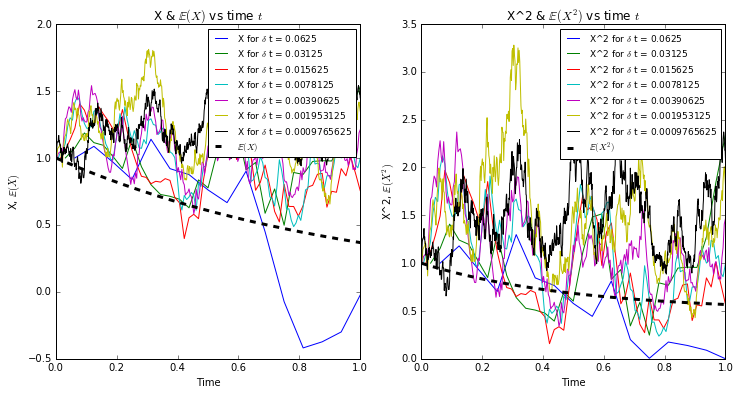

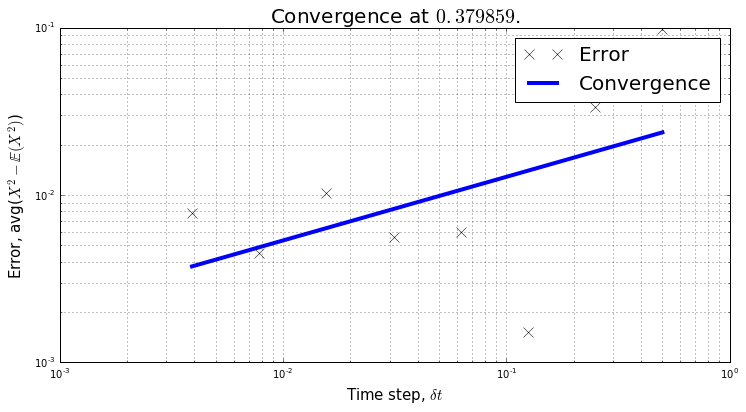

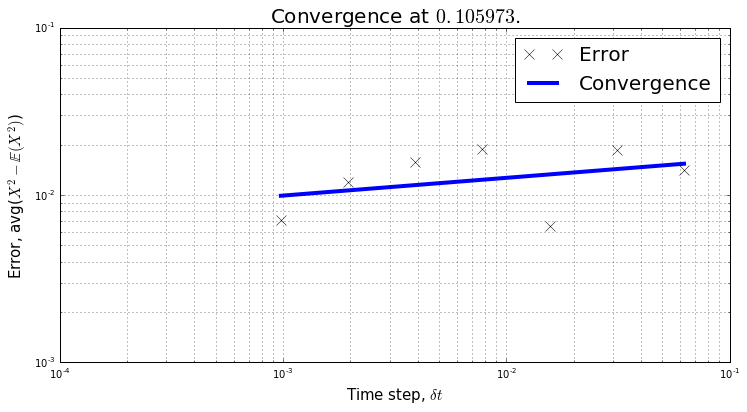

In [35]:
# plot the graphs a single run of the EM algorithm
plot_graphs(4,10, EM)

#get the convergence for a lower range
plot_conver(1, 8, 5000, EM)

# get the convergence for the required range of timesteps
plot_conver(4, 10, 5000, EM)

#### Task 1 Discussion

For 1 single realisation, it can be seen that for any timestep, the EM algorithm has the ability not to follow the expected solution. However, if the mean is taken at each time point, for all timesteps (seen below), it can be seen that they follow the expected solution almost exactly. This behaviour is observed both for X & X^2. 

If we look at the convergence starting from a larger timestep to a smaller one, the bigger (closer to 2) both the larger & smaller timesteps, the closer the system tends to has a converging order 1, as expected for a a weak convergence. 
Moreover, depending on the random walk, different runs of the code can prompt negative convergence. It can also be observed at smaller timesteps, the error can increase, although it was expected to decrease. This is due to the fact that lower timesteps, the stochastic term takes precedence over the deterministic part. However, the error could be reduced by increasing the number of realisation, but this would require a long computing time.  

/PhD/Software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/PhD/Software/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/PhD/Software/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


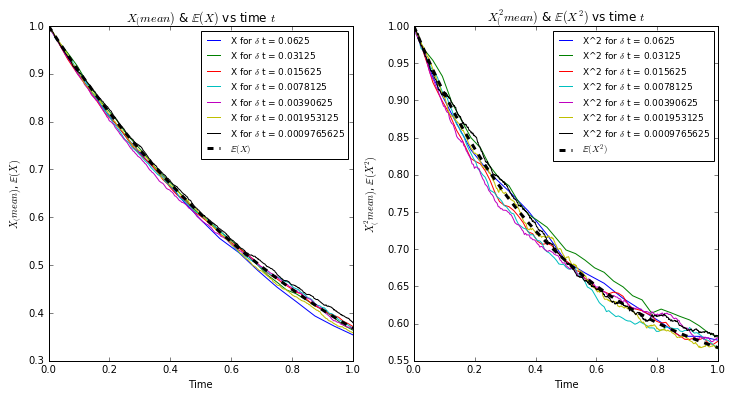

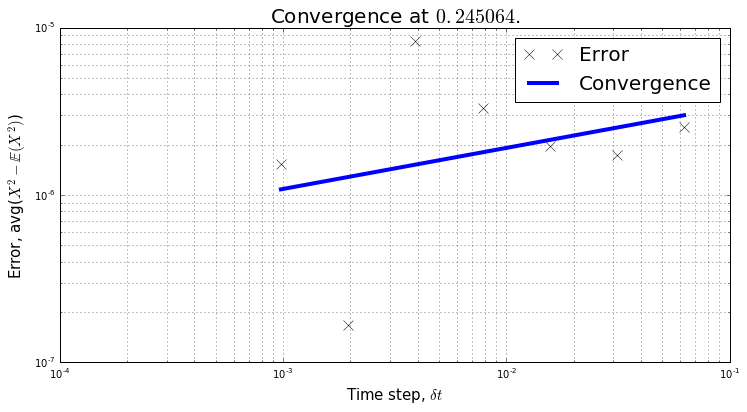

In [14]:
plot_graphs_mean(4, 10, EM, 4000)
plot_conver_mean(4, 10, 4000, EM)

### Task 2 

In [37]:
def histogram_data(T, dt, realisations, f):
    """
    This function takes another function f (EM or theta_method), does the stochastic approach for 
    the number of realisations given at the given timestep dt. 
    It then returns the last element, the X(T), for all realisation, so the distribution of results
    can be seen.
    
    Parameters
    T - int / int
        the final time for which the stochastic approach will be calculated, from 0 to T
    
    dt - float
        timestep which defines the calculation of the function. Over the time period, the timestep
        will be used to calculate at each point
        
    realisation - int
            the number of realisations for which the method will be used. The function will be
            run for a number of realisation over the time period with a timestep dt
            
    f - function
        the different function which calculated the solution of the Ornstein-Uhlenbeck.
    
    Return
    X - numpy array(realisations)
        the array containing the value given by the stochastic function f at time T, for each realisation
    """
    assert type(T) == int or type(T) == numpy.int or type(T) == float or type(T) == numpy.float64, \
        "T is not an integer. It is {}.".format(type(T))
    assert type(dt) == int or type(dt) == float or type(dt) == numpy.float64, \
        "dt is not a float or int. It is {}.".format(type(dt))
    assert type(realisations) == int, \
        "realisations is not an integer. It is {}.".format(realisations)
    assert isinstance(f, types.FunctionType), \
        "f is not a function. It is {}.".format(type(f))
    
    #initialise parameters
    X0, l, u, TT , theta = init_vals()
    DT = numpy.sqrt(dt)
    N = int(T / dt)
    X = numpy.zeros(realisations)
    t_range = numpy.linspace(0, T, N+1)
    
    #get the last step for each realisation
    for i in range(realisations):
        dW = numpy.random.randn(N+1) * DT
        X[i] = f(X0, t_range, l, u, dW, theta)[-1]
        
    assert type(X) == numpy.ndarray, \
        "X is not an array. it is {}.".format(type(X))
    assert X.shape == (realisations,), \
        "X does not have the correct shape. Current shape is {}.".format(X.shape)
    assert (X != 0).any(), \
        "X is full of zeros, values were not put in."
        
    return X

In [38]:
def plot_histogram(results, bins):
    """
    Function that plots a histogram of the results of calculating the function using different stochastic methods. 
    
    Parameters:
    results - numpy array (N,)
        array containing the last element from a stochastic method of computing the value 
        of the investigated function, for N realisations
        
    bins - int
        the number of bins to separate date into. 
    """
    assert type(results) == numpy.ndarray or type(results) == list, \
        "results not the correct type. Current type is {}.".format(type(results))
        
    assert type(bins) == int, \
        "bins is not an integer. It currently is {}.".format(type(bins))
    assert bins > 0, \
        "bins must be higher than zero"
    pyplot.figure(figsize=(12,6))
    pyplot.hist(results, bins)
    pyplot.title("Histogram")
    pyplot.xlabel("X values")
    pyplot.ylabel("Number of realisations")
    pyplot.show()

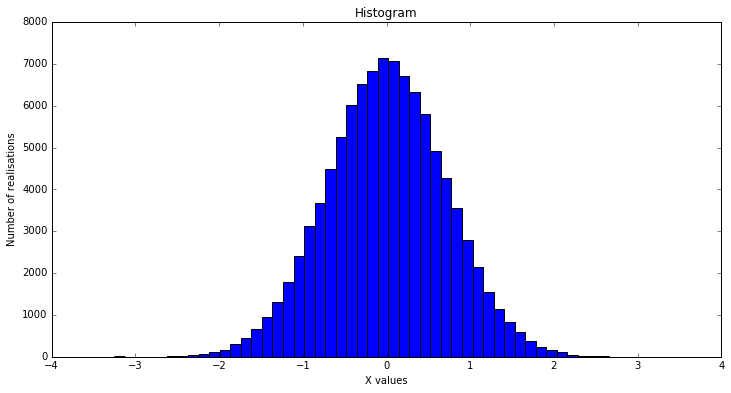

In [41]:
X = histogram_data(10, 2**-7, 10**5, EM)
plot_histogram(X, 50)

In [108]:
X0, l, u, TT, theta = init_vals()
t_range = numpy.linspace(0, 10, 2**7+1)
ex_sol = EX(X0, t_range, l)
print("The expected solution for T=10 is {:.7f}.".format(ex_sol[-1]))
print("Number of elements ±0.5 from this value is {}.".format(numpy.logical_and(X>=-0.5+ex_sol[-1], X<=0.5+ex_sol[-1]).sum()))
print("Number of elements 100% from this value is {}.".format(numpy.logical_and(X>=0, X<=2*ex_sol[-1]).sum()))

The expected solution for T=10 is 0.0000454.
Number of elements ±0.5 from this value is 70329.
Number of elements 100% from this value is 520.


#### Discussion

In can be observed from the histogram, that the distribution of solutions from a stochastic follows a Gaussian distribution with the main peak around 0 (or so it can be observed). This behaviour was expected, as the expected solution is 4.54e-5 (very close to 0).

While the majority of the solutions lay around 0 (with 70.3% in this case) being contained ±0.5 from 0, it can be observed that some values are quite far from 0. This behaviour is mainly due to the stochastic element of Euler_Maruyama system. 

### Task 3

In [61]:
def is_in_distribution(X, dt):
    """
    Function that computes if the solutions of N realisations of a stochastic method fall in a normal distribution.
    
    Parameter
    X - numpy array(N,)
        array containing the kast element of the solutions of N realisation using a 
        stochastic method of calculating the function
    
    dt - float
        timestep for the stochastic method
        
    Return
    None
    However, the function prints if the variance falls in the normal distribution both for X & X^2.
    """
    
    assert type(X) == numpy.ndarray or type(X) == list, 
        "X is not the correct type. It is {}.".format(type(X)) 
    assert (X != 0).any(), \
        "X contains only zeros."
    assert type(dt) == float or type(dt) == numpy.float64 or type(dt) == int, \
        "dt not the correct type. It is {}.".format(type(dt))
        
    X0, l, u, T, theta = init_vals()
    
    #get the distribution
    distribution = numpy.array((0, u**2 / (2 * l - l**2 * dt)))

    var_X = numpy.var(X)
    var_X2 = numpy.var(X**2)

    if var_X >= distribution[0] and var_X <= distribution[1]:
        print("The variance of X falls between the normal distribution. \n Variance of X = {:.4f}".format(var_X))
    else:
        print("The variance of X does not fall between the normal distribution. \n Lower bound = {:.4f} \n Upper bound {:.4f} \n Variance of X = {:.4f}".format(*distribution, var_X))

    if var_X2 >= distribution[0] and var_X2 <= distribution[1]:
        print("The variance of X^2 falls between the normal distribution. \n Variance of X^2 = {:.4f}".format(var_X2))
    else:
        print("The variance of X^2 does not fall between the normal distribution. \n Lower bound = {:.4f} \n Upper bound {:.4f} \n Variance of X^2 = {:.4f}".format(*distribution, var_X2))

In [62]:
is_in_distribution(X)

The variance of X does not fall between the normal distribution. 
 Lower bound = 0.0000 
 Upper bound 0.5020 
 Variance of X = 0.5023
The variance of X^2 does not fall between the normal distribution. 
 Lower bound = 0.0000 
 Upper bound 0.5020 
 Variance of X^2 = 0.5064


#### Discussion

It can be seen that for the variance of X, depending on the run, the volue is either between the bounds or just over the upper bound. Even when it is between the bounds, it is very close to the upper bound. This osciallation around the upper bound is given by the stochasticity of the method used. 

While the given T is considered large enough, it can thus be seen that even for a large T, with this implementation, the final solution just barely reaches a normal distribution. But still reaches. 

### Task 4

In [71]:
def theta_method(X0, t_range, l, u, dW, theta):
    """
    Function similar to EM (Euler-Maruyama). It calculates the solution to the Ornstein-Uhlenbeck problem 
    using the theta method, instead of the EM algorithm.
    
    The theta method works similar to the EM method, however, some parts (especially the deterministic part), 
    are more restrained. Again, the first element in the array is initialised as X0, with the remaining elements
    being dependend on the previous elements & a stochastic part as:
    
        X_(n+1) = X_n - limba * dt * theta * X_(n+1) - lamba * deltat * (1 - theta) * X_n + miu * dW_n
        
    dW represents the stochastic part of the problem, the random walk.
    
    Parameters:
    X0 - float
        initial value of the function at time 0
        
    t_range - numpy array (N)
            array containing the times steps at which the function will be computed, starting from 0 to T in N steps
            
    l - float
        lambda paramter used in defining the EM problem
    
    u - float
        miu parameter used in defining the EM problem
        
    dW - numpy array (N,)
        array containing the random walk terms, associated with each timestep required in the 
        stochastic method.
        
    theta - float
            the theta parameter required for the theta method
            
    Return
    X - numpy array (N, )
        array containing the values of the solution of the Ornstein-Uhlenbeck problem for the 
        given paramters.
    """
    
    assert type(X0) == int or type(X0) == float or type(X0) == numpy.float64, \
        "X0 not the correct type in theta_method. Current type = {}.".format(type(X0))
    assert type(t_range) == numpy.ndarray, \
        "t_range not the correct type in theta_method. Current type = {}.".format(type(t_range))
    assert t_range.dtype == numpy.float64, \
        "t_range not the correct ndtype in theta_method. Current type = {}.".format(t_range.dtype)
    assert (t_range != 0).any(), \
        "t_range does not contain other values than 0."
    assert type(l) == int or type(l) == float or type(l) == numpy.float64, \
        "l not the correct type in theta_method. Current type = {}.".format(type(l))
    assert type(u) == int or type(u) == float or type(u) == numpy.float64, \
        "u not the correct type in theta_method. Current type = {}.".format(type(u))
    assert type(dW) == numpy.ndarray, \
        "dW not the correct type in theta_method. Current type = {}.".format(type(dW))
    assert dW.dtype == numpy.float64, \
        "t_range not the correct ndtype in theta_method. Current type = {}.".format(dW.dtype)
    assert (dW != 0).any(), \
        "t_range does not contain other values than 0."
    assert (t_range.shape == dW.shape), \
        "t_range and dW not the same shape. Current shapes are {} and {}.".format(t_range.shape, dW.shape)
    assert type(theta) == int or type(theta) == float or type(theta) == numpy.float64, \
        "theta not the correct type in theta_method. Current type = {}.".format(type(theta))
   
   
    X = numpy.zeros_like(dW)
    X[0] = X0
    dt = t_range[1] - t_range[0]
    
    for i, dw in enumerate(dW[:-1]):
        X[i+1] = (X[i] - l * dt * (1 - theta) * X[i] + u * dw) / (1  + l * dt * theta)
    
    assert type(t_range) == type(X), \
        "X not the correct type in theta_method. Current type = {}.".format(type(X))
    assert t_range.dtype == X.dtype, \
        "X not the correct ndtype in theta_method. Current type = {}.".format(X.dtype)
    assert t_range.shape == X.shape, \
        "X does not have the same shape in theta_method. Current shape = {}.".format(X.shape)
    assert (X != 0).any(), \
        "X does not contain other values than 0."
    
    return X

/PhD/Software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/PhD/Software/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


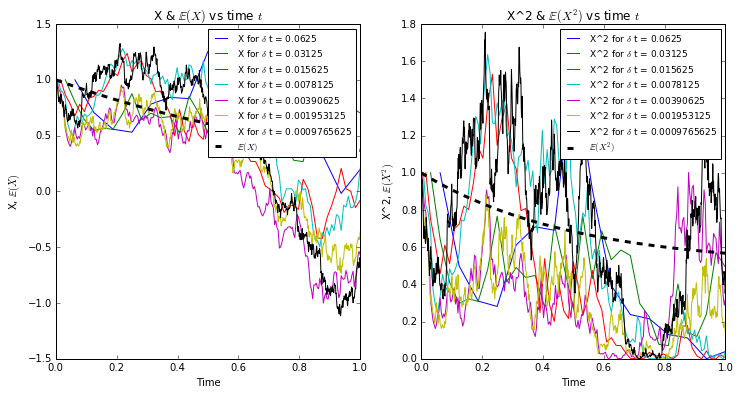

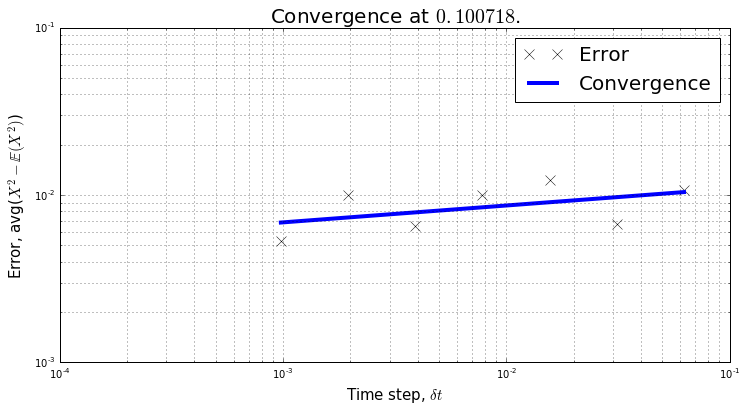

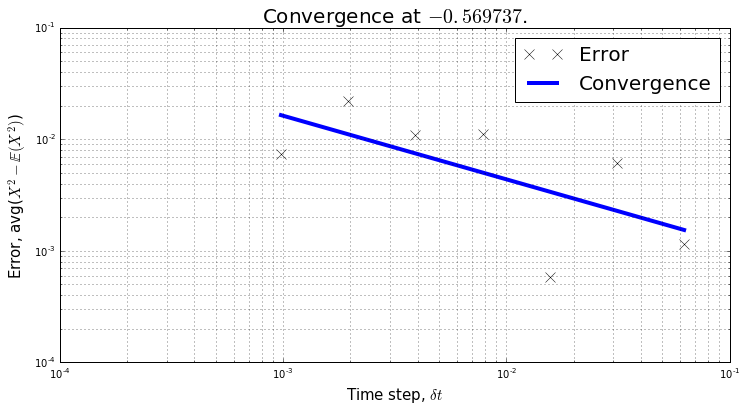

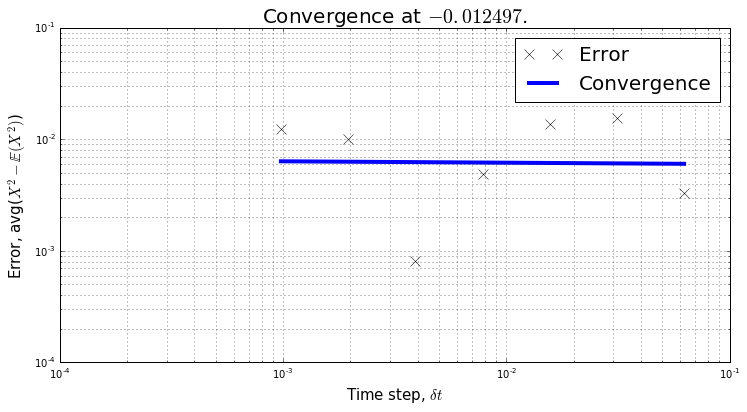

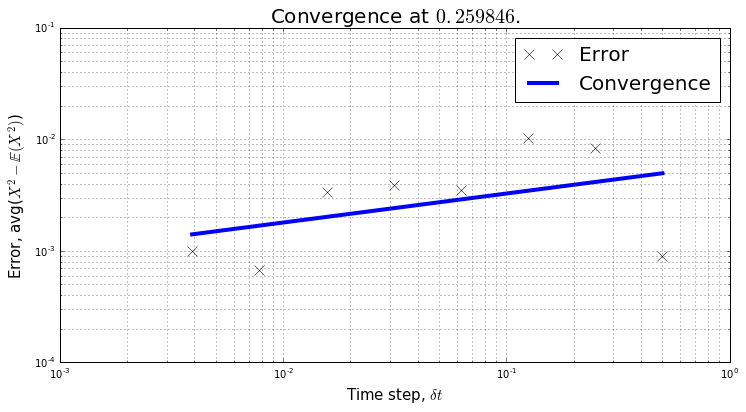

In [107]:
plot_graphs(4,10, theta_method)
plot_conver(4, 10, 5000, theta_method)
plot_conver(4, 10, 5000, theta_method)
plot_conver(4, 10, 5000, theta_method)
plot_conver(1, 8, 5000, theta_method)

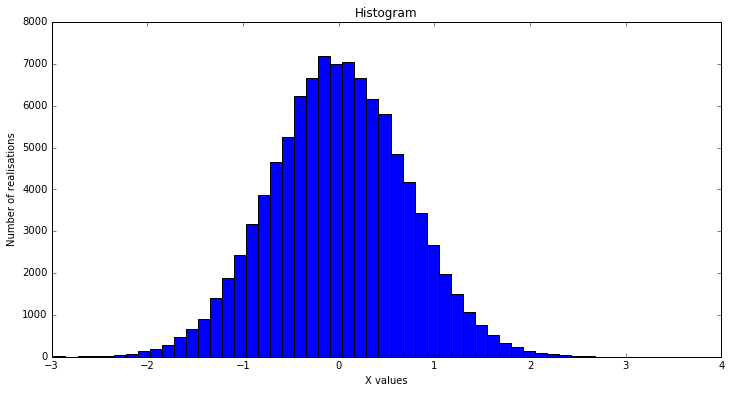

The expected solution for T=10 is 0.0000454.
Number of elements ±0.5 from this value is 52541.
Number of elements 100% from this value is 4.


In [109]:
X_theta = histogram_data(10, 2**-7, 10**5, theta_method)
plot_histogram(X_theta, 50)
print("The expected solution for T=10 is {:.7f}.".format(ex_sol[-1]))
print("Number of elements ±0.5 from this value is {}.".format(numpy.logical_and(X_theta>=-0.5+ex_sol[-1], X_theta<=0.5+ex_sol[-1]).sum()))
print("Number of elements 100% from this value is {}.".format(numpy.logical_and(X_theta>=0, X_theta<=2*ex_sol[-1]).sum()))

In [110]:
is_in_distribution(X_theta)

The variance of X falls between the normal distribution. 
 Variance of X = 0.4958
The variance of X^2 falls between the normal distribution. 
 Variance of X^2 = 0.5014


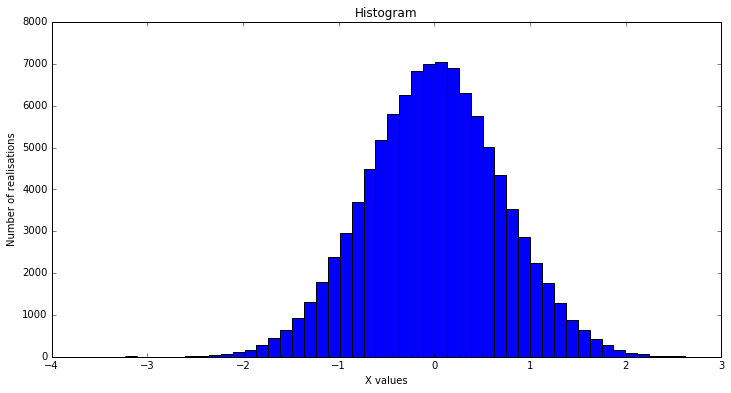

The expected solution for T=10 is 0.0000454.
Number of elements ±0.5 from this value is 52082.
Number of elements 100% from this value is 9.
The variance of X falls between the normal distribution. 
 Variance of X = 0.5005
The variance of X^2 falls between the normal distribution. 
 Variance of X^2 = 0.4990


In [111]:
X_theta = histogram_data(10, 2**-7, 10**5, theta_method)
plot_histogram(X_theta, 50)
print("The expected solution for T=10 is {:.7f}.".format(ex_sol[-1]))
print("Number of elements ±0.5 from this value is {}.".format(numpy.logical_and(X_theta>=-0.5+ex_sol[-1], X_theta<=0.5+ex_sol[-1]).sum()))
print("Number of elements 100% from this value is {}.".format(numpy.logical_and(X_theta>=0, X_theta<=2*ex_sol[-1]).sum()))
is_in_distribution(X_theta)

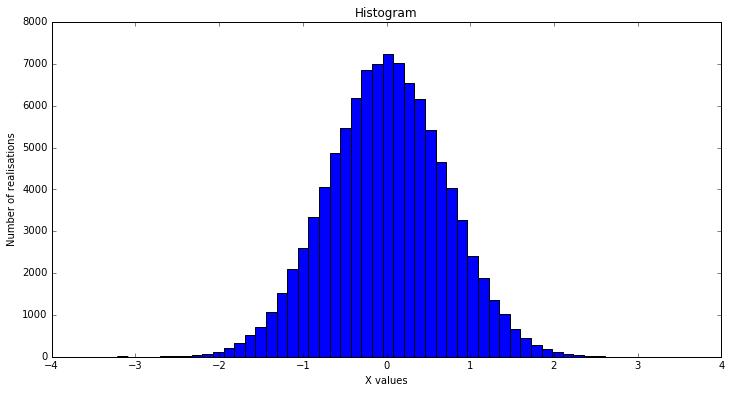

The expected solution for T=10 is 0.0000454.
Number of elements ±0.5 from this value is 52005.
Number of elements 100% from this value is 2.
The variance of X falls between the normal distribution. 
 Variance of X = 0.5000
The variance of X^2 falls between the normal distribution. 
 Variance of X^2 = 0.4963


In [112]:
X_theta = histogram_data(10, 2**-7, 10**5, theta_method)
plot_histogram(X_theta, 50)
print("The expected solution for T=10 is {:.7f}.".format(ex_sol[-1]))
print("Number of elements ±0.5 from this value is {}.".format(numpy.logical_and(X_theta>=-0.5+ex_sol[-1], X_theta<=0.5+ex_sol[-1]).sum()))
print("Number of elements 100% from this value is {}.".format(numpy.logical_and(X_theta>=0, X_theta<=2*ex_sol[-1]).sum()))
is_in_distribution(X_theta)

#### Discussion

Using the theta method, some different results were achieved, compared with the Euler-Maruyama method.
In the theta method, while all coefficients of the equation are divided by a certain number, the deterministic part has a reduced impact on the outcome, compared with EM, as the second term has an additional factor smaller than 1. 

Firstly, it can be seen that the convergence has both similar and different properties, depending on the stochastic part. It can be seen for larger timesteps, the system still converges, but at a lower rate. However, for smaller timesptes(4 to 10), the system either tends to converge to a low order, or diverge. This is expected, as the stochastic part has a higher impact on the equation. This was seen also in EM at very small timesteps, while here is seen from the beginning. 

The histograms show similar behaviours as in the EM case, with the majority of the elements around the zero mark. 

Lastly, it was observed that the variance has decreased, with every simulation being inside the limit. However, the decrease compared with the EM method is relatively small (3e-3 typically, or less than 1%). This implies that while the normal distribution is achieved consistently, it does not provide a real benefit.  

In [75]:
rock_on()

\m/(**)\m/


In [103]:
# testing

## Self consistent fields - Water

Perform the self-consistent field calculation for a water molecule, $\text{H}_2\text{O}$.

### Parameters

The locations of the atoms are:

In [85]:
R_O = [0.0, 1.809*numpy.cos(104.52/180.0*numpy.pi/2.0), 0.0]
R_H1 = [-1.809*numpy.sin(104.52/180.0*numpy.pi/2.0), 0.0, 0.0]
R_H2 = [+1.809*numpy.sin(104.52/180.0*numpy.pi/2.0), 0.0, 0.0]

The nuclear repulsion energy is:

In [86]:
Vnn = 8.90770810

The overlap matrix is:

In [87]:
S = numpy.array([[ 1.       ,  0.2367039,  0.       ,  0.       , -0.       ,
         0.0500137,  0.0500137],
       [ 0.2367039,  1.       ,  0.       ,  0.       , -0.       ,
         0.4539953,  0.4539953],
       [ 0.       ,  0.       ,  1.       ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  1.       ,  0.       ,
         0.2927386, -0.2927386],
       [-0.       , -0.       ,  0.       ,  0.       ,  1.       ,
         0.2455507,  0.2455507],
       [ 0.0500137,  0.4539953,  0.       ,  0.2927386,  0.2455507,
         1.       ,  0.2510021],
       [ 0.0500137,  0.4539953,  0.       , -0.2927386,  0.2455507,
         0.2510021,  1.       ]])

The core Hamiltonian is:

In [88]:
H = numpy.array([[ -3.26850823e+01,  -7.60432270e+00,   0.00000000e+00,
          0.00000000e+00,  -1.86797000e-02,  -1.61960350e+00,
         -1.61960350e+00],
       [ -7.60432270e+00,  -9.30206280e+00,   0.00000000e+00,
          0.00000000e+00,  -2.22159800e-01,  -3.54321070e+00,
         -3.54321070e+00],
       [  0.00000000e+00,   0.00000000e+00,  -7.43083560e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -7.56702220e+00,   0.00000000e+00,  -1.89085610e+00,
          1.89085610e+00],
       [ -1.86797000e-02,  -2.22159800e-01,   0.00000000e+00,
          0.00000000e+00,  -7.52665570e+00,  -1.65878930e+00,
         -1.65878930e+00],
       [ -1.61960350e+00,  -3.54321070e+00,   0.00000000e+00,
         -1.89085610e+00,  -1.65878930e+00,  -4.95649010e+00,
         -1.56026360e+00],
       [ -1.61960350e+00,  -3.54321070e+00,   0.00000000e+00,
          1.89085610e+00,  -1.65878930e+00,  -1.56026360e+00,
         -4.95649010e+00]])

The number of electrons is:

In [89]:
Nelectrons = 10

The two electron integrals are given in the data file:

In [90]:
G=numpy.fromfile('./H2O-two-electron.dat')
G = numpy.reshape(G,(7,7,7,7));

### Plotting

There is useful information contained in the basis functions. The calculations here used the *STO-3G* basis, which are Gaussians with carefully chosen coefficients. There is one basis function per atomic orbital: so one for each hydrogen (the "1s" orbital) and five for the oxygen (one for the "1s" orbital, one for the "2s" orbital, and three for the "2p" orbitals - one for each Cartesian direction, associated with the quantum spins). Each basis function is written
$$
  \tilde{\chi} (r) = \sum_{i=1}^3 c_{i} \left( \frac{2 \alpha_i}{\pi} \right)^{3/4} e^{-\alpha_i r^2},
$$
where $r$ is the distance to the nucleus of this particular atom, and the $c_i, \alpha_i$ coefficients depend on the atom and the orbital.

For the "1s" orbitals the values of the coefficients are
$$
\begin{align}
  c_1 &= 0.444635, & c_2 &= 0.535328, & c_3 &= 0.154329, \\
  \alpha_1 &= 0.109818 \zeta_1^2, & \alpha_2 &= 0.405771 \zeta_1^2, & \alpha_3 &= 2.22766 \zeta_1^2.
\end{align}
$$
Here $\zeta_1 = 1.24$ for hydrogen and $\zeta_1 = 7.66$ for oxygen.

For the "2s" orbital the coefficients are
$$
\begin{align}
  c_1 &= 0.700115, & c_2 &= 0.399513, & c_3 &= -0.0999672, \\
  \alpha_1 &= 0.0751386 \zeta_2^2, & \alpha_2 &= 0.231031 \zeta_2^2, & \alpha_3 &= 0.994203 \zeta_2^2.
\end{align}
$$
Here $\zeta_2 = 2.25$ for oxygen.

Finally, for the "2p" orbital, the coefficients are
$$
\begin{align}
  c_1 &= 0.391957, & c_2 &= 0.607684, & c_3 &= 0.1559163, \\
  \alpha_1 &= 0.0751386 \zeta_2^2, & \alpha_2 &= 0.231031 \zeta_2^2, & \alpha_3 &= 0.994203 \zeta_2^2.
\end{align}
$$

In the above matrices, the seven entries correspond to:
$$
\begin{align}
  0 &: \text{Oxygen, 1s}, \\
  1 &: \text{Oxygen, 2s}, \\
  2 &: \text{Oxygen, 2p (x)}, \\
  3 &: \text{Oxygen, 2p (y)}, \\
  4 &: \text{Oxygen, 2p (z)}, \\
  5 &: \text{Hydrogen (1), 1s}, \\
  6 &: \text{Hydrogen (2), 1s}.
\end{align}
$$

### Constructing the full molecular orbitals

Given these basis functions, the single orbital molecular orbitals can be constructed as
$$
  \chi_i = \sum_{\mu=1}^K C_{i\mu} \tilde{\chi}_{\mu}.
$$
The iso-surfaces of the molecular orbitals give useful information about the reaction properties of the molecule.

### Tasks

1. Compute the total energy using the self-consistent field method. Ensure that your code prints the energy to the screen and returns the basis coefficients $C$ for later use.
2. Construct the molecular orbitals and plot isocontours of each in the $x-y$ plane.

### Task 1 

In [77]:
def transf_matrix(S):
    """
    Function that computes the transformation matrix X, given S the overlap matrix between the basis functions.
    
    Paramteres:
    S - numpy array  (N, N)
        the overlap matrix between the basis functions
        
    Returns
    X - numpy array (N, N)
        the transformation matrix
    """
    assert type(S) == numpy.ndarray, \
        "S is not a numpy array in transf_matrix. It is currently a {}.".format(type(S))
    assert S.shape[0] == S.shape[1], \
        "S must be a square matrix in transf_matrix. It's current shape is {}.".format(S.shape)
    Delta, U = numpy.linalg.eig(S)
    Delta = numpy.diag(Delta**(-1/2))
    X = numpy.dot(U, numpy.dot(Delta, numpy.conj(U).T))
    assert (X.shape == S.shape), \
        "X is not the same shape as S in transf_matrix. It's current shape is {}.".format(X.shape)
    return X

In [78]:
def density_matrix(C, N):
    """Function that computes the density matrix D, given the number of electrons and the 
    basis coefficients as a matrix C.
    
    Paramters
    C - numpy array (n, n)
        matrix containing the coefficients of the basis faunctions
        
    N - int
        number of electrons in the molecule
        
    Return 
    D - numpy array (n, n)
        matrix containing the density matrix in the field"""
    
    assert type(C) == numpy.ndarray, \
        "C is not a numpy array. It currently is {}.".format(type(C))
    assert C.shape[0] == C.shape[1], \
        "C is not a square matrix. It's currently shape is {}.".format(C.shape)
    assert type(N) == int or type(N) == numpy.int, \
        "N is not an integer. It currently is {}.".format(type(N))
    
    N_e = int(numpy.around(N/2+0.49))
    uv, n = C.shape
    D = numpy.zeros([uv, uv])
    for u in range(uv):
        for v in range(uv):
            for j in range(N_e):
                D[u, v] += 2 * C[u, j] * C[v, j]
    assert D.shape == C.shape, \
        "D was not properly created. It's current shape is {}.".format(D.shape)
    return D


In [80]:
def fock_matrix(H, G, D):
    """
    Function that computes the fock matrix.
    
    Paramters
    H - numpy array (N, N)
        matrix containing the one-electron integrals 
    G - numpy array (N, N) 
        matrix containing the two-electron integrals
    D - numpy array (n, n)
        matrix containing the density matrix in the field
        
    Return
    F - numpy array (N, N)
        matrix containing the fock matrix elements
    """
    assert type(H) == numpy.ndarray, \
        "H is not a numpy array. It currently is {}.".format(type(H))
    assert type(G) == numpy.ndarray, \
        "G is not a numpy array. It currently is {}.".format(type(G))
    assert type(D) == numpy.ndarray, \
        "D is not a numpy array. It currently is {}.".format(type(D))
    assert H.shape[0] == H.shape[1], \
        "H is not square matrix. It's current shape is {}.".format(H.shape)
    assert G.shape[0] == G.shape[1], \
        "G is not square matrix. It's current shape is {}.".format(G.shape)
    assert D.shape[0] == D.shape[1], \
        "D is not square matrix. It's current shape is {}.".format(D.shape)
    assert D.shape[0] == G.shape[0] and D.shape[0] == H.shape[0], \
        "H , G, D are not the same shape."
    miu, niu = H.shape
    alpha, beta = D.shape
    F = numpy.copy(H)
    for u in range(miu):
        for v in range(miu):
            for alpha in range(miu):
                for beta in range(miu):
                    F[u, v] += (G[u, v, alpha, beta] -
                                  0.5 * G[u, beta, alpha, v]) * D[alpha,
                                                                    beta]
    assert F.shape == H.shape, \
        "F was not created properly in fock_matrix. It's current shape is {}.".format(F.shape)
    assert (F.any != 0), \
        "F was not created properly in fock_matrix. It is a 0 matrix."
    
    return F

In [81]:
def orb_energya(F, X):
    """
    function which computes the new orbital energy and the matrix C containing the coefficients for the 
    basis functions.
    
    Parameters
    F - numpy array (N, N)
        matrix containing the fock matrix elements
    X - numpy array (N, N)
        the transformation matrix
    
    Return
    epsilon - numpy array (N,)
            array containing the orbital energies for the assumed layers
    C - numpy array (N, N)
        matrix containing the coefficients of the basis faunctions
    """
    assert type(F) == numpy.ndarray, \
        "F is not a numpy array. It currently is {}.".format(type(F))
    assert F.shape[0] == F.shape[1], \
        "F is not square matrix. It's current shape is {}.".format(F.shape)
    assert type(X) == numpy.ndarray, \
        "X is not a numpy array. It currently is {}.".format(type(X))
    assert X.shape[0] == X.shape[1], \
        "X is not square matrix. It's current shape is {}.".format(X.shape)
    
    
    F_p = numpy.dot(numpy.conj(X).T, numpy.dot(F, X))  
    epsilon, V = numpy.linalg.eigh(F_p)
    
    ID = numpy.argsort(epsilon)
    epsilon = epsilon[ID]
    V = V[:, ID]
    C = numpy.dot(X, V)
    
    assert epsilon.shape[0] == F.shape[0], \
        "epsilon does not have the correct shape. It curretly has {}.".format(epsilon.shape)
    assert C.shape[0] == F.shape[0] and C.shape[0] == C.shape[1], \
        "C is not a square matrix and the same shape as F&X. It's current shape is {}.".format(C.shape)
    return epsilon, C

In [82]:
def D_new(X, H, G, C, D, Ne):
    """
    Function that calculates a new desity matrix based on the old density matrix D.
    
    Parameters
    X - numpy array (N, N)
        the transformation matrix
    H - numpy array (N, N)
        matrix containing the one-electron integrals 
    G - numpy array (N, N) 
        matrix containing the two-electron integrals
    C - numpy array (N, N)
        matrix containing the coefficients of the basis faunctions
    D - numpy array (n, n)
        matrix containing the density matrix in the field
    Ne - int
        number of electrons in the molecule
        
    Return:
    D - numpy array (n, n)
        matrix containing the density matrix in the field
    C - numpy array (N, N)
        matrix containing the coefficients of the basis faunctions
    V - numpy array (N,)
            array containing the orbital energies for the assumed layers
    """
    assert type(X) == numpy.ndarray, \
        "X is not a numpy array. It currently is {}.".format(type(X))
    assert X.shape[0] == X.shape[1], \
        "X is not square matrix. It's current shape is {}.".format(X.shape)
    N = X.shape[0]
    assert type(H) == numpy.ndarray, \
        "H is not a numpy array. It currently is {}.".format(type(H))
    assert type(G) == numpy.ndarray, \
        "G is not a numpy array. It currently is {}.".format(type(G))
    assert type(D) == numpy.ndarray, \
        "D is not a numpy array. It currently is {}.".format(type(D))
    assert H.shape[0] == H.shape[1], \
        "H is not square matrix. It's current shape is {}.".format(H.shape)
    assert G.shape[0] == G.shape[1], \
        "G is not square matrix. It's current shape is {}.".format(G.shape)
    assert D.shape[0] == D.shape[1], \
        "D is not square matrix. It's current shape is {}.".format(D.shape)
    assert D.shape[0] == G.shape[0] and D.shape[0] == H.shape[0], \
        "H , G, D are not the same shape."
    assert type(C) == numpy.ndarray, \
        "C is not a numpy array. It currently is {}.".format(type(C))
    assert C.shape[0] == C.shape[1], \
        "C is not a square matrix. It's currently shape is {}.".format(C.shape)
    assert D.shape[0] == N, \
        "D is not the same shape as X. It is {}, while it should be {}.".format(D.shape, X.shape)
    assert H.shape[0] == N, \
        "H is not the same shape as X. It is {}, while it should be {}.".format(H.shape, X.shape)
    assert G.shape[0] == N, \
        "G is not the same shape as X. It is {}, while it should be {}.".format(G.shape, X.shape)
    assert C.shape[0] == N, \
        "C is not the same shape as X. It is {}, while it should be {}.".format(C.shape, X.shape)
    assert type(N) == int, \
        "N is not an int. It is {}.".format(type(N))
    
    F = fock_matrix(H, G, D)
    V, C = orb_energya(F, X)
    D = density_matrix(C, Ne)
    return D, C, V

In [83]:
def give_me_ma_energy(D, H, F, Vnn):
    """
    Function that returns the total energy of the configuration. 
    
    Parameters:
    D - numpy array (n, n)
        matrix containing the density matrix in the field
    H - numpy array (N, N)
        matrix containing the one-electron integrals 
    F - numpy array (N, N)
        matrix containing the fock matrix elements
    Vnn - float
        nucleon-nucleon interaction energy
        
    Return 
    Energy - float
        the total energy of the system
    """
    assert type(H) == numpy.ndarray, \
        "H is not a numpy array. It currently is {}.".format(type(H))
    assert type(F) == numpy.ndarray, \
        "F is not a numpy array. It currently is {}.".format(type(F))
    assert type(D) == numpy.ndarray, \
        "D is not a numpy array. It currently is {}.".format(type(D))
    assert H.shape[0] == H.shape[1], \
        "H is not square matrix. It's current shape is {}.".format(H.shape)
    assert F.shape[0] == F.shape[1], \
        "F is not square matrix. It's current shape is {}.".format(F.shape)
    assert D.shape[0] == D.shape[1], \
        "D is not square matrix. It's current shape is {}.".format(D.shape)
    N = D.shape[0]
    assert H.shape[0] == N, \
        "H is not the same shape as X. It is {}, while it should be {}.".format(H.shape, D.shape)
    assert F.shape[0] == N, \
        "F is not the same shape as X. It is {}, while it should be {}.".format(F.shape, D.shape)   
    assert type(Vnn) == int or type(Vnn) == float or type(Vnn) == numpy.float64, \
        "Vnn is not a recognised type. Current type is {}.".format(type(Vnn))
        
    return numpy.sum(D * (H + F)) / 2.0 + Vnn

In [91]:
def hartrees(S, H, G, Vnn, C, Ne = Nelectrons, tol = 1e-13):
    """
    Function which iterates the Hartree-Fock method until it converges to a certain tolerance. 
    It return the total energy of the system and the matrix C containing the coefficienct of the basis functions.
    
    Parameters:
    S - numpy array  (N, N)
        the overlap matrix between the basis functions
    H - numpy array (N, N)
        matrix containing the one-electron integrals 
    G - numpy array (N, N) 
        matrix containing the two-electron integrals
    Vnn - float
        nucleon-nucleon interaction energy
    C - numpy array (N, N)
        matrix containing the coefficients of the basis faunctions. I
    tol - float
        the tolerance to which the system should try and converge. 
        
    Return
    E - float
        the total energy of the configuration
    C - numpy array (N, N)
        matrix containing the coefficients of the basis faunctions. I
    """
    assert type(S) == numpy.ndarray, \
        "S is not a numpy array in transf_matrix. It is currently a {}.".format(type(S))
    assert S.shape[0] == S.shape[1], \
        "S must be a square matrix in transf_matrix. It's current shape is {}.".format(S.shape)
    assert type(H) == numpy.ndarray, \
        "H is not a numpy array. It currently is {}.".format(type(H))
    assert type(G) == numpy.ndarray, \
        "G is not a numpy array. It currently is {}.".format(type(G))
    assert H.shape[0] == H.shape[1], \
        "H is not square matrix. It's current shape is {}.".format(H.shape)
    assert G.shape[0] == G.shape[1], \
        "G is not square matrix. It's current shape is {}.".format(G.shape)
    assert type(C) == numpy.ndarray, \
        "C is not a numpy array. It currently is {}.".format(type(C))
    assert C.shape[0] == C.shape[1], \
        "C is not a square matrix. It's currently shape is {}.".format(C.shape)
    N = S.shape[0]
    assert H.shape[0] == N, \
        "H is not the same shape as S. It is {}, while it should be {}.".format(H.shape, S.shape)
    assert G.shape[0] == N, \
        "G is not the same shape as S. It is {}, while it should be {}.".format(G.shape, S.shape)
    assert C.shape[0] == N, \
        "C is not the same shape as S. It is {}, while it should be {}.".format(C.shape, S.shape)
    assert type(Vnn) == int or type(Vnn) == float or type(Vnn) == numpy.float64, \
        "Vnn is not a recognised type. Current type is {}.".format(type(Vnn))
    assert type(tol) == int or type(tol) == float or type(tol) == numpy.float64, \
        "tol is not a recognised type. Current type is {}.".format(type(tol))
    
    X = transf_matrix(S)
    D = density_matrix(C, Ne)
    error = 10.0
    i = 0
    while error > tol:
        D_old = D
        X = transf_matrix(S)
        D, C, OE = D_new(X, H, G, C, D, Ne)
        error = numpy.sum(abs(D - D_old))
        i+=1
        if i>10000:
            print("System did not converge after 10000 iterations.")
            break
    F = fock_matrix(H, G, D)
    E = give_me_ma_energy(D, H, F, Vnn)
    assert type(E) == int or type(E) == float or type(E) == numpy.float64, \
        "E is not a recognised type. Current type is {}.".format(type(E))
    
    print("System converged after {} iterations, for a {} tolerance.".format(i, tol))
    
    return E, C

In [92]:
# execute theenergy solver
C = numpy.zeros_like(H)
Energy, C = hartrees(S, H, G, Vnn, C)

System converged after 40 iterations, for a 1e-13 tolerance.


In [93]:
print("The total energy of the self contained field is {}.".format(Energy))
print("The C matrix is: \n C = {}.".format(C))

The total energy of the self contained field is -74.96590106014918.
The C matrix is: 
 C = [[ -9.94216113e-01  -2.33759162e-01   1.36349265e-15  -1.04048978e-01
   -1.92161682e-16  -1.25835897e-01  -3.92047506e-16]
 [ -2.58496205e-02   8.44396663e-01  -6.66133815e-15   5.38240140e-01
    8.91584688e-16   8.20344352e-01   2.74780199e-15]
 [  1.53962937e-19  -5.64413164e-17  -6.13987702e-16   2.10903903e-15
   -1.00000000e+00  -3.84351772e-19  -1.65310491e-16]
 [  2.42861287e-16  -2.77555756e-17   6.12709764e-01   6.25888230e-15
   -2.06748235e-16   2.67841305e-15  -9.59851297e-01]
 [ -4.16576583e-03   1.22891080e-01   9.65894031e-15  -7.55881905e-01
   -1.78494626e-15   7.63598631e-01   2.72004641e-15]
 [  5.58518679e-03   1.55605150e-01   4.49219057e-01  -2.95059588e-01
   -7.13695596e-16  -7.69244378e-01   8.14766242e-01]
 [  5.58518679e-03   1.55605150e-01  -4.49219057e-01  -2.95059588e-01
    1.37252549e-16  -7.69244378e-01  -8.14766242e-01]].


#### Discussion 

In [94]:
# Testing

def test_transf_matrix():
    """
    Function that test transf_matrix. 
    """
    S = numpy.array([[1.0, 0.434311], [0.434311, 1.0]])
    X = transf_matrix(S)
    assert (X.shape == S.shape), \
        "the shape is not the same"
    X_c = numpy.array([[ 1.08227706, -0.24729271],[-0.24729271,  1.08227706]])    
    assert numpy.allclose(X, X_c), \
        "X & X_C from class is not the same."
    print("passed tests transf_matrix")
    
    return X

def test_density_matrix():
    """Function that test density_matrix"""
    C = numpy.array([[1,2],[3,4]])
    N = 2
    D = density_matrix(C, N)
    assert (C.shape == D.shape), \
        "D is not the proper shape"
    # test against class values
    D_test = numpy.array([[  2. ,  6.], [  6. , 18.]])
    assert numpy.allclose(D_test, D), \
        "Not the correct values"
    print("test density matrix passed")
    return D

def test_fock_matrix():
    """Function that tests fock_matrix"""
    H = numpy.array([[-1.559058, -1.111004], [-1.111004, -2.49499]])
    G = numpy.array([[[[ 0.77460594,  0.27894304],[ 0.27894304,  0.52338927]],
                  [[ 0.27894304,  0.14063907],[ 0.14063907,  0.34321967]]],
                 [[[ 0.27894304,  0.14063907],[ 0.14063907,  0.34321967]],
                  [[ 0.52338927,  0.34321967],[ 0.34321967,  1.05571294]]]])
    D = test_density_matrix()
    F = fock_matrix(H, G, D)
    assert (F.shape == H.shape), \
        "F does not have the proper shape"
    # test against class tests
    F_test = numpy.array([[ 9.04446141,  1.95249989],
                           [ 1.95249989,  9.97188395]])
    assert numpy.allclose(F, F_test), \
        "F does not have the good values"
    print("fock matrix test passed")
    return F

def test_orb_energya():
    """
    Function that test the orb_energya function.
    """
    F = test_fock_matrix()
    X = test_transf_matrix()
    E, C = orb_energya(F, X)
    assert (E.shape[0] == F.shape[0]), \
        "E not the correct shape"
    assert (C.shape == F.shape), \
        "F not the proper shape"
    # vallues from class test
    E_test = numpy.array([  7.94142798,  13.40552417])
    C_test = numpy.array([[-0.67674817, -0.8800507 ],
        [-0.49879792,  0.9918054 ]])
    assert numpy.allclose(E, E_test), \
        "E values are not proper."
    assert numpy.allclose(C, C_test), \
        "C values not proper."
    return E, C

def test_D_new():
    """
    Funtion that tests the D_new function.
    """
    C = numpy.array([[1,2],[3,4]])
    Ne = 2
    H = numpy.array([[-1.559058, -1.111004], [-1.111004, -2.49499]])
    G = numpy.array([[[[ 0.77460594,  0.27894304],[ 0.27894304,  0.52338927]],
                  [[ 0.27894304,  0.14063907],[ 0.14063907,  0.34321967]]],
                 [[[ 0.27894304,  0.14063907],[ 0.14063907,  0.34321967]],
                  [[ 0.52338927,  0.34321967],[ 0.34321967,  1.05571294]]]])
    X = test_transf_matrix()
    D = test_density_matrix()
    D, C, V = D_new(X, H, G, C, D, Ne)
    assert (D.shape == H.shape), \
        "D does not have the proper shape"
    assert (C.shape == H.shape), \
        "C does not have the proper shape"
    assert (V.shape[0] == H.shape[0]), \
        "V does not have the proper shape"
    D_test = numpy.array([[ 0.91597617,  0.67512116],
                          [ 0.67512116,  0.49759874]])
    C_test = numpy.array([[-0.67674817, -0.8800507 ],
                          [-0.49879792,  0.9918054 ]])
    V_test = numpy.array([  7.94142798,  13.40552417])
    assert numpy.allclose(D, D_test), \
        "D does not have the proper values"
    assert numpy.allclose(C, C_test), \
        "C does not have the proper values"
    assert numpy.allclose(V, V_test), \
        "V does not have the proper values"
    print("test D_new passed")
    return D, C, V

def test_give_me_ma_energy():
    """
    function that tests give_me_ma_energy function.
    """
    Vnn = 1.3668670357
    D = test_density_matrix()
    F = test_fock_matrix()
    H = numpy.array([[-1.559058, -1.111004], [-1.111004, -2.49499]])
    energy = give_me_ma_energy(D, H, F, Vnn)
    assert type(energy) == int or type(energy) == float or type(energy) == numpy.float64, \
        "energy not the proper type"
    # class values
    energy_test = 81.19329133570001
    assert numpy.allclose(energy, energy_test), \
        "energy not proper values"
    print("test give_me_ma_energy passed")
    return None

def test_hartrees():
    """
    function that test the hartrees function.
    """
    S = numpy.array([[1.0, 0.434311], [0.434311, 1.0]])
    H = numpy.array([[-1.559058, -1.111004], [-1.111004, -2.49499]])
    G = numpy.array([[[[ 0.77460594,  0.27894304],[ 0.27894304,  0.52338927]],
                  [[ 0.27894304,  0.14063907],[ 0.14063907,  0.34321967]]],
                 [[[ 0.27894304,  0.14063907],[ 0.14063907,  0.34321967]],
                  [[ 0.52338927,  0.34321967],[ 0.34321967,  1.05571294]]]])
    Vnn = 1.3668670357
    C = numpy.zeros((2,2))
    E, C = hartrees(S, H, G, Vnn, C, Ne=2)
    assert type(E) == int or type(E) == float or type(E) == numpy.float64, \
        "E not the proper type."
    # class lab values
    energy_test = -2.6261330459085817
    assert numpy.allclose(E, energy_test), \
        "Energy not the proper value"
    print("test hartrees passed")
    return None

def test_all_p2_p1():
    test_transf_matrix()
    test_density_matrix()
    test_fock_matrix()
    test_orb_energya()
    test_D_new()
    test_give_me_ma_energy()
    test_hartrees()
    print("all tests passed")
    rock_on()
    
test_all_p2_p1()

passed tests transf_matrix
test density matrix passed
test density matrix passed
fock matrix test passed
test density matrix passed
fock matrix test passed
passed tests transf_matrix
passed tests transf_matrix
test density matrix passed
test D_new passed
test density matrix passed
test density matrix passed
fock matrix test passed
test give_me_ma_energy passed
System converged after 20 iterations, for a 1e-13 tolerance.
test hartrees passed
all tests passed
\m/(**)\m/


### Task 2

In [95]:
def get_points(side, points):
    """
    Function that creates the mesh grid for the coordinates of each point in the grid.
    
    Parameters
    side - float
        the length of each side (NSEW) from origin 0, 0, 0
    points - float
        the number of points in the grid on each side
        
    Return
    grid - numpy array (points+1, points+1, 3)
        the grid containing the position on X, Y, Z from origin of each point of the grid
    """
    assert type(side) == int or type(side) == float or type(side) == numpy.float64, \
        "side is not a recognised type. Current type is {}.".format(type(side))
    assert type(points) == int or type(points) == float or type(points) == numpy.float64, \
        "points is not a recognised type. Current type is {}.".format(type(points))
    
    points += 1
    dims = numpy.linspace(-side, side, points)
    grid = numpy.zeros((points, points, 3))
    for i in range(points):
        for j in range(points):
            grid[j, i, 0] = dims[i]
            grid[j, i, 1] = dims[j]
            grid[j, i, 2] = 0
    return grid

In [96]:
def make_coeff():
    """
    Function that returns the coefficients for used in the basis functions for both 
    the oxygen & hydrogen.
    
    Returns
    coeff_H - numpy array (2, 3)
            array containing the coefficients for the 1s orbital for the hydrogen atoms
            
    coeff_O - numpy array (3, 2, 3)
            array containing the coefficients for the 1s, 2s & 2p orbitals for the oxygen atoms
    """
    # zets
    swiggle1_O = 7.66
    swiggle1_H = 1.24
    swiggle2_O = 2.25
    
    # create the initial coefficients matrix, having c on first line & a on the second line
    coeff_H = numpy.array([[0.444635, 0.535328, 0.154329], 
                           [0.109818, 0.405771, 2.22766]])
    
    coeff_O = numpy.array([[[0.444635, 0.535328, 0.154329], 
                           [0.109818, 0.405771, 2.22766]],
                           
                          [[0.700115, 0.399513, -0.0999672],
                           [0.0751386, 0.231031, 0.994203]],
                           
                          [[0.391957, 0.607684, 0.1559163],
                           [0.0751386, 0.231031, 0.994203]]])
    
    # update the a coefficients with zeta^2
    coeff_H[1] *= swiggle1_H**2
    coeff_O[0, 1] *= swiggle1_O**2
    coeff_O[1, 1] *= swiggle2_O**2
    coeff_O[2, 1] *= swiggle2_O**2
    
    return [coeff_H, coeff_O]


In [97]:
def CHI_bar(coeff, r):
    """
    Function that computes the chi_bar for a given position & atom
    
    Parameters
    coeff - numpy array (2, 3 ~ expected, but can be 2, N)
            array containing the c & a orbital coefficients
    r - float
        distance to the an atoms from a given grid point
        
    Return
    chi_bar - float
            the basis function value
    """
    assert type(r) == int or type(r) == float or type(r) == numpy.float64, \
        "r is not a recognised type. Current type is {}.".format(type(r))
    assert type(coeff) == numpy.ndarray, \
        "coeff is not the peoper type. it is {}.".format(type(coeff))
    assert coeff.shape[0] == 2, \
        "coeff is not the proper shape. it is {}.".format(coeff.shape)
    
    return (coeff[0] * (2 * coeff[1] / numpy.pi)**0.75 * numpy.exp(-coeff[1] * r * r)).sum()

In [98]:
def CHI_miu(coeff, xy):
    """
    Function that computes all tha 7 basis function at a given point in space. 
    
    Parameters
    coeff - list (2,)
            list containing the basis function coefficience for the H atoms (0) as a (2,3) numpy array
            and coefficiences for the O atms (1) as a (3, 2, 3) numpy array
    xy = numpy array (3,)
            array containing the position of a given point in space, wrt origin (0, 0, 0)
            
    return
    X - numpy array (7,)
        the chi_miu values of the basis function for all the required energy levels
    """
    assert type(coeff) == list, \
        "coeff is not the peoper type. it is {}.".format(type(coeff))
    assert len(coeff) == 2, \
        "coeff is not the proper shape. it is {}.".format(len(coeff))
    assert type(coeff[0]) == numpy.ndarray, \
        "H coeff not a np array"
    assert coeff[0].shape[0] == 2, \
        "H coeff not the right shape."
    assert type(coeff[1]) == numpy.ndarray, \
        "O coeff not a np array"
    assert coeff[1].shape[0] == 3 and coeff[1].shape[1] == 2, \
        "O coeff not the right shape"
        
    assert type(xy) == numpy.ndarray, \
        "xy not the right type."
    assert xy.shape[0] == 3, \
        "xy not the right shape"
    
    X = numpy.zeros(7)
    r_o = numpy.linalg.norm(xy - R_O)
    r_h1 = numpy.linalg.norm(xy - R_H1)
    r_h2 = numpy.linalg.norm(xy - R_H2)
    X[0] = CHI_bar(coeff[1][0], r_o)
    X[1] = CHI_bar(coeff[1][1], r_o)
    X[2] = CHI_bar(coeff[1][2], r_o)
    X[3] = CHI_bar(coeff[1][2], r_o)
    X[4] = CHI_bar(coeff[1][2], r_o)
    X[5] = CHI_bar(coeff[0], r_h1)
    X[6] = CHI_bar(coeff[0], r_h2)
    
    return X

    

In [99]:
def CHI_matrix(C, side, points):
    """
    Function that calculates the molecular orbitals for each of the second levels, for each point
    in a grid with (points+1, points+1) size, and both x & y ranging from (-side, side)
    Parameters
    C - numpy array (N, N)
        matrix containing the coefficients of the basis faunctions. I
    side - float
        the length of each side (NSEW) from origin 0, 0, 0
    points - float
        the number of points in the grid on each side
    
    Return
    X - numpy array (points+1, points+1, 7)
        the chi matrix containing for each grid points the 7 molecular orbital enegies
    """
    assert type(C) == numpy.ndarray, \
        "C is not a numpy array. It currently is {}.".format(type(C))
    assert C.shape[0] == C.shape[1], \
        "C is not a square matrix. It's currently shape is {}.".format(C.shape)
    assert type(side) == int or type(side) == float or type(side) == numpy.float64, \
        "side is not a recognised type. Current type is {}.".format(type(side))
    assert type(points) == int or type(points) == float or type(points) == numpy.float64, \
        "points is not a recognised type. Current type is {}.".format(type(points))
    
    # create the grid points
    grid = get_points(side, points)
    X = numpy.zeros((points+1, points+1, 7))
    # get the function basis coefficients
    coeff = make_coeff()
    
    for i in range(points+1):
        for j in range(points+1):
            # calculate the molecular orbitals for each level at i & j position on the grid 
            X_miu = CHI_miu(coeff, grid[i,j])
            for k in range(X_miu.shape[0]):
                # actually get them summed
                X[i,j, k] = (C[k] * X_miu).sum()
    return X 



In [38]:
%matplotlib notebook 

/PhD/Software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


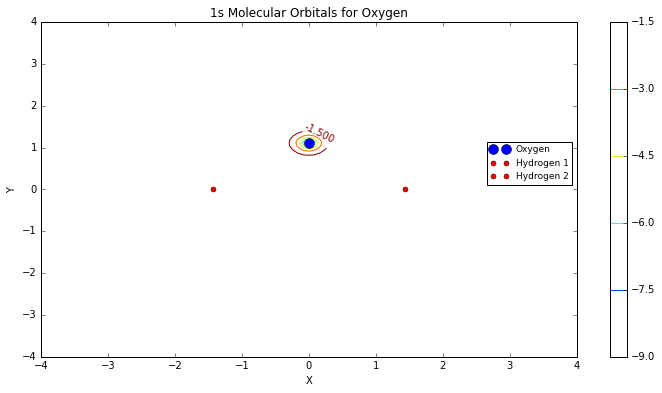

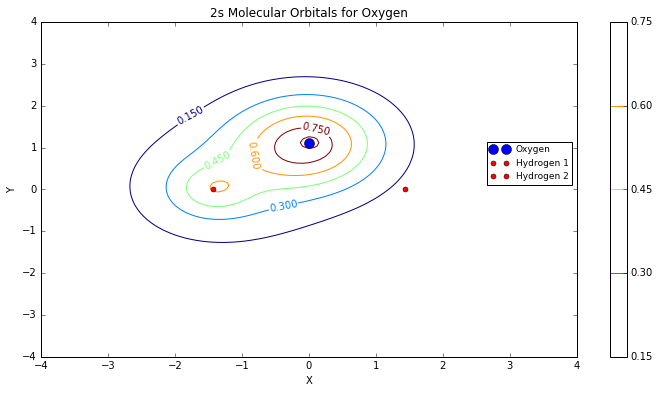

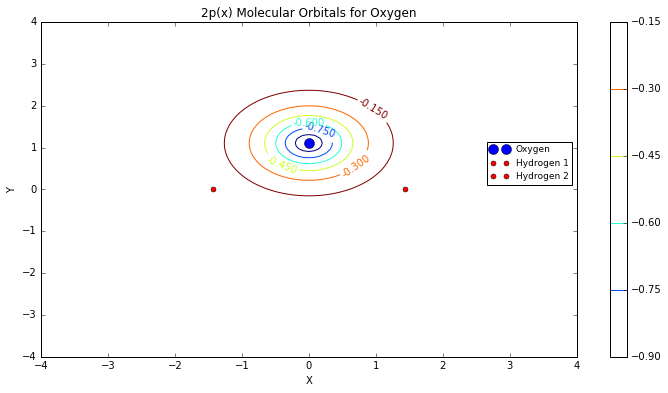

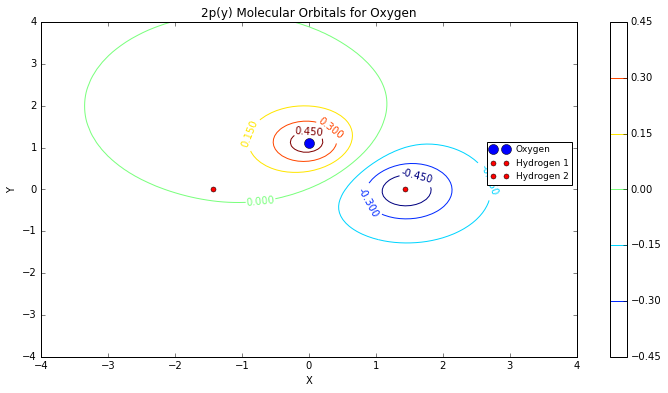

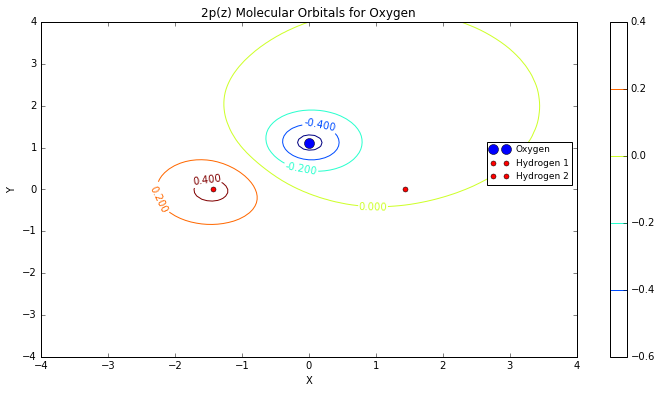

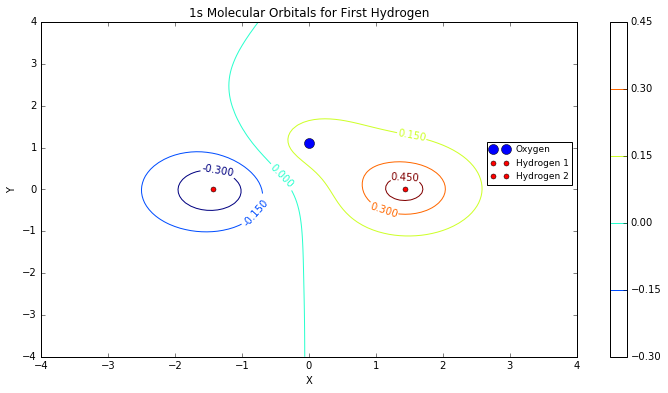

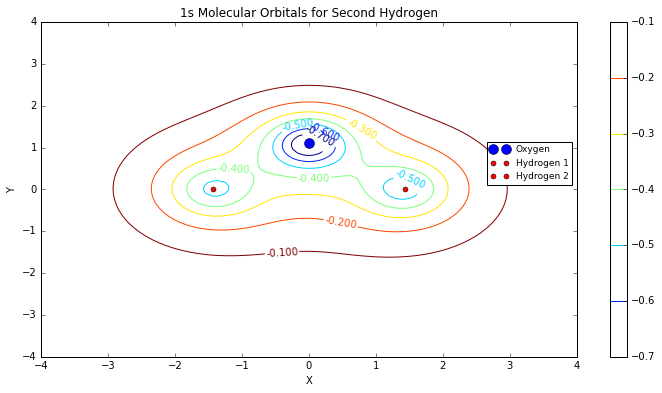

In [102]:
points = 100 # number of points in the grid
side = 4 # side length of the grid 
X = CHI_matrix(C, side, points) # calculate the orbitals
x = y = numpy.linspace(-side, side, points+1) # get the x & y axis

# list of titles for the plots
labels1 = ['1s Molecular Orbitals for Oxygen', 
          '2s Molecular Orbitals for Oxygen', 
          '2p(x) Molecular Orbitals for Oxygen', 
          '2p(y) Molecular Orbitals for Oxygen',
          '2p(z) Molecular Orbitals for Oxygen', 
          '1s Molecular Orbitals for First Hydrogen', 
          '1s Molecular Orbitals for Second Hydrogen']

# plot the wavefunctions
for i in range(C.shape[0]):
    fig = pyplot.figure(figsize=(12,6), dpi=100)
    ax = fig.add_subplot(111)
    contoor = ax.contour(x, y, X[:,:,i], n_lines = 1000)
    ax.plot(R_O[0], R_O[1], 'bo', ms=10, label='Oxygen')
    ax.plot(R_H1[0], R_H1[1], 'ro', ms=5, label='Hydrogen 1')
    ax.plot(R_H2[0], R_H2[1], 'ro', ms=5, label='Hydrogen 2')
    ax.clabel(contoor, inline=1, fontsize=10)
    ax.legend(fontsize=9, loc='lower right', bbox_to_anchor=[1,0.5])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(labels1[i])
    fig.colorbar(contoor)

/PhD/Software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


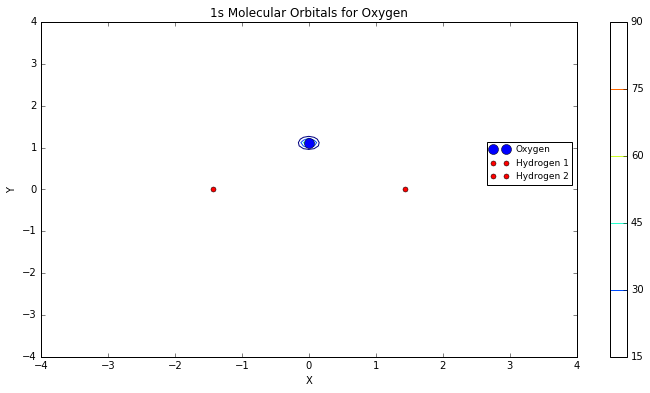

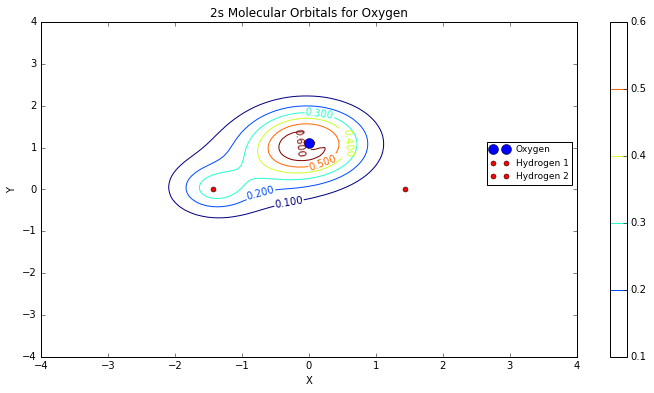

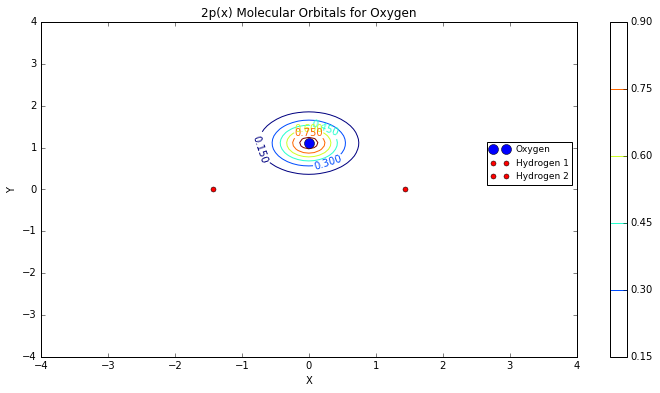

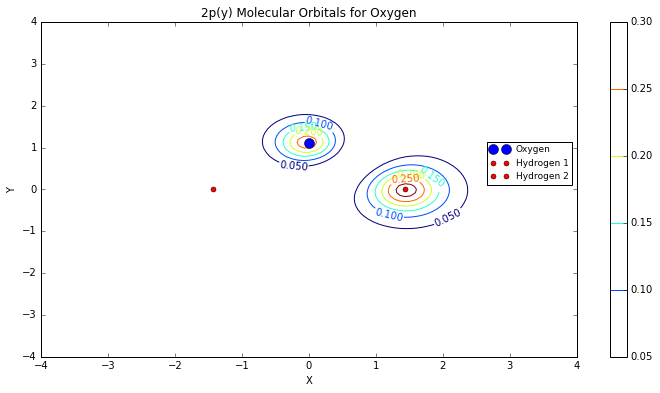

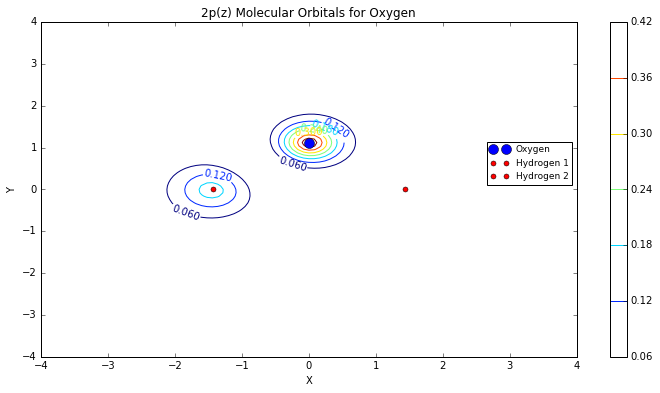

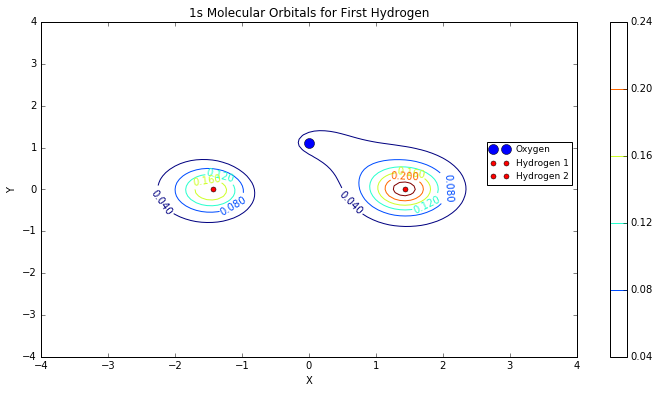

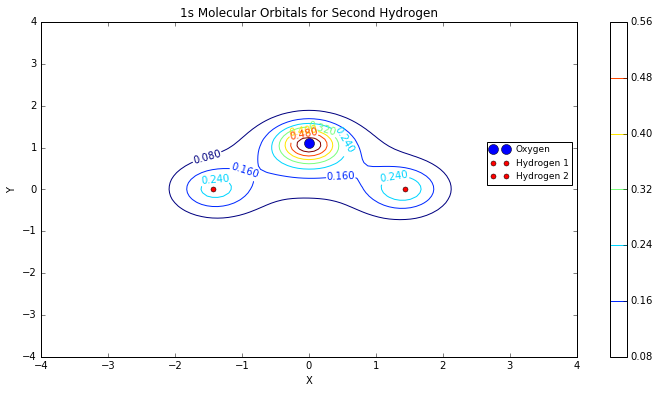

In [114]:
# plot the density probability
labels1 = ['1s Density for Oxygen', 
          '2s Density for Oxygen', 
          '2p(x) Density for Oxygen', 
          '2p(y) Density for Oxygen',
          '2p(z) Density for Oxygen', 
          '1s Density for First Hydrogen', 
          '1s Density for Second Hydrogen']

for i in range(C.shape[0]):
    fig = pyplot.figure(figsize=(12,6), dpi=100)
    ax = fig.add_subplot(111)
    contoor = ax.contour(x, y, X[:,:,i]**2, n_lines = 1000)
    ax.plot(R_O[0], R_O[1], 'bo', ms=10, label='Oxygen')
    ax.plot(R_H1[0], R_H1[1], 'ro', ms=5, label='Hydrogen 1')
    ax.plot(R_H2[0], R_H2[1], 'ro', ms=5, label='Hydrogen 2')
    ax.clabel(contoor, inline=1, fontsize=10)
    ax.legend(fontsize=9, loc='lower right', bbox_to_anchor=[1,0.5])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(labels[i])
    fig.colorbar(contoor)

#### Discussion

The first set of plots, the molecular orbitals represent the wave function of the electrons in the molecule. By squaring them, the second set of plots was obtained. Those show the probability of electrons to be in those locations, for different levels of energy. 

For 1s 2p(x) level, the electrons are very close to the oxygen. This behaviour was expected, as the bonds are stronger, and these represent the main oxygen atom levels. 

The remaining plots show how for the other levels of energy, the electrons are shared between the atoms. As such, it can be seen that while the electrons are shared, the molecule (the atoms) stays together, without breaking. 

In [101]:
def test_get_points():
    grid = get_points(2, 4)
    grid_test = numpy.array([[[-2., -2., 0.],
                              [-1., -2., 0.],
                              [ 0., -2., 0.],
                              [ 1., -2., 0.],
                              [ 2., -2., 0.]],
                             [[-2., -1., 0.],
                              [-1., -1., 0.],
                              [ 0., -1., 0.],
                              [ 1., -1., 0.],
                              [ 2., -1., 0.]],
                             [[-2.,  0., 0.],
                              [-1.,  0., 0.],
                              [ 0.,  0., 0.],
                              [ 1.,  0., 0.],
                              [ 2.,  0., 0.]],
                             [[-2.,  1., 0.],
                              [-1.,  1., 0.],
                              [ 0.,  1., 0.],
                              [ 1.,  1., 0.],
                              [ 2.,  1., 0.]],
                             [[-2.,  2., 0.],
                              [-1.,  2., 0.],
                              [ 0.,  2., 0.],
                              [ 1.,  2., 0.],
                              [ 2.,  2., 0.]]])
    assert type(grid) == numpy.ndarray, \
        "grid is not a numpy array"
    assert grid.shape == grid_test.shape, \
        "the grids have the same shape"
    assert numpy.allclose(grid, grid_test), \
        "the grid does not have the proper values. check that is was deployed properly."
    print("test get_points passed")


def test_make_coeff():
    coeffs = make_coeff()
    
    assert type(coeffs) == tuple or type(coeffs) == list, \
        "the return is not created well. it should be a list or tuple."
    assert coeffs[0].shape == (2,3), \
        "the first coeffs does not have proper shape."
    assert (coeffs[0] != 0).all(), \
        "no element should be 0"
    assert coeffs[1].shape == (3,2,3), \
        "coeffs_O was not properly created."
    assert (coeffs[1] != 0).all(), \
        "no element should be 0"
    print("test make_coeff passed")

    
def test_CHI_bar():
    coeff = make_coeff()
    coeffs = numpy.zeros((4, 2, 3))
    coeffs[0] = coeff[0]
    coeffs[1:] = coeff[1]
    
    for part in coeffs:
        r = numpy.random.random() * 10 - 5
        test_chi_bar = 0
        for j in range(3):
            test_chi_bar += part[0, j] * (2 * part[1, j] / numpy.pi)**0.75 * numpy.exp(-part[1, j] * r * r)
        chi_bar = CHI_bar(part, r)
        assert type(chi_bar) == float or type(chi_bar) == numpy.float64, \
            "chi_bar did not create a proper type value"
        assert numpy.allclose(chi_bar, test_chi_bar), \
            "Chi_bar did not compute proper values"
    print("chi_bar test passed")
    return test_chi_bar


def test_CHI_miu():
    xy = numpy.random.rand(3)
    coeff = make_coeff()
    X = numpy.zeros(7)
    r_o = numpy.linalg.norm(xy - R_O)
    r_h1 = numpy.linalg.norm(xy - R_H1)
    r_h2 = numpy.linalg.norm(xy - R_H2)
    for j in range(3):
        X[0] += coeff[1][0][0, j] * (2 * coeff[1][0][1, j] / numpy.pi)**0.75 * numpy.exp(-coeff[1][0][1, j] * r_o * r_o)
        X[1] += coeff[1][1][0, j] * (2 * coeff[1][1][1, j] / numpy.pi)**0.75 * numpy.exp(-coeff[1][1][1, j] * r_o * r_o)
        X[2] += coeff[1][2][0, j] * (2 * coeff[1][2][1, j] / numpy.pi)**0.75 * numpy.exp(-coeff[1][2][1, j] * r_o * r_o)
        X[3] += coeff[1][2][0, j] * (2 * coeff[1][2][1, j] / numpy.pi)**0.75 * numpy.exp(-coeff[1][2][1, j] * r_o * r_o)
        X[4] += coeff[1][2][0, j] * (2 * coeff[1][2][1, j] / numpy.pi)**0.75 * numpy.exp(-coeff[1][2][1, j] * r_o * r_o)
        X[5] += coeff[0][0, j] * (2 * coeff[0][1, j] / numpy.pi)**0.75 * numpy.exp(-coeff[0][1, j] * r_h1 * r_h1)
        X[6] += coeff[0][0, j] * (2 * coeff[0][1, j] / numpy.pi)**0.75 * numpy.exp(-coeff[0][1, j] * r_h2 * r_h2)
    CHI = CHI_miu(coeff, xy)
    assert CHI.shape[0] == 7, \
        "CHI_miu did not create the proper array"
    assert (CHI != 0).any(), \
        "everything is 0."
    assert numpy.allclose(CHI, X), \
        "CHI_miu has not created the values as expected."
    print("CHI_MIU test passed.")

def test_CHI_matrix():
    CHI = CHI_matrix(C, 2, 5)
    assert type(CHI) == numpy.ndarray, \
        "CHI is not the correct type."
    assert CHI.shape == (6, 6, 7), \
        "CHI_Matrix not the proper shape"
    assert (CHI != 0).any(), \
        "CHI is all 0."
    assert CHI.dtype == numpy.float64, \
        "CHI does not have the proper type inside."
        
    coeff = make_coeff()
    grid = get_points(2, 5)
    for test in range(10):
        x = numpy.random.randint(6)
        y = numpy.random.randint(6)
        X_miu = CHI_miu(coeff, grid[x, y])
        X = numpy.zeros(7)
        for i in range(7):
            X[i] = (C[i] * X_miu).sum()
        assert numpy.allclose(X, CHI[x, y]), \
            "Not correct values."
            
    print("CHI_matrix test passed")
        
def test_all_p2_p2():
    test_get_points()
    test_make_coeff()
    test_CHI_bar()
    test_CHI_miu()
    test_CHI_matrix()
    print("all tests passed.")
    rock_on()

test_all_p2_p2()

test get_points passed
test make_coeff passed
chi_bar test passed
CHI_MIU test passed.
CHI_matrix test passed
all tests passed.
\m/(**)\m/
